In [75]:
import SimDAT2D.SimDAT2D as sim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IsoDAT2D.IsoDAT2D as iso
from PIL import Image
import pyFAI, fabio
from pyFAI.gui import jupyter
import pyFAI
import os
import matplotlib.pyplot as plt
from tifffile import imread
from SimDAT2D import masking
import pyFAI.azimuthalIntegrator as AI
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [10]:
def create_mask_for_tiff(tiff_path, width):
    """
    This function creates a mask for the azimuthal integrator from a TIFF file.
    
    Parameters:
        tiff_path (str): Path to the TIFF file
        width (int): The width of the line of interest
    """
    # Import tiff file
    from tifffile import imread
    image = imread(tiff_path)
    
    # Get the center point (assuming square image)
    center = image.shape[0] // 2
    
    # Create the mask
    mask = np.ones_like(image)
    mask[center-width:center+width, center:] = 0
    
    # Display the mask
    plt.figure(figsize=(5, 5))
    plt.imshow(mask, cmap='viridis')
    plt.title("Mask")
    plt.show()
    
    return mask

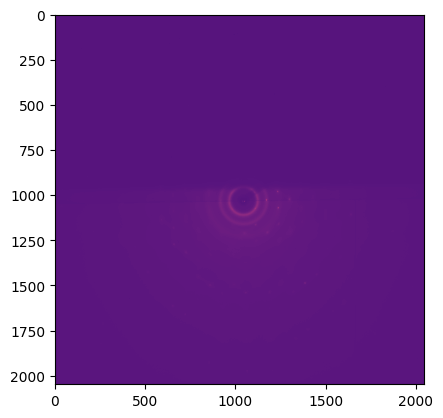

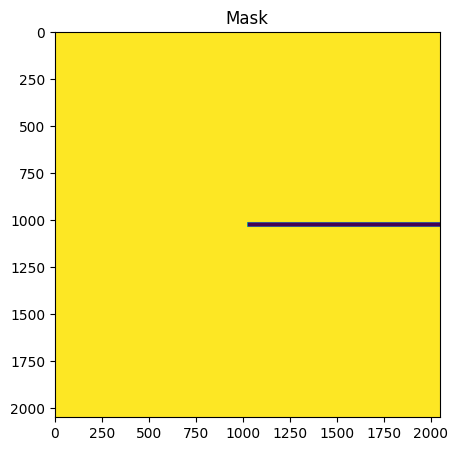

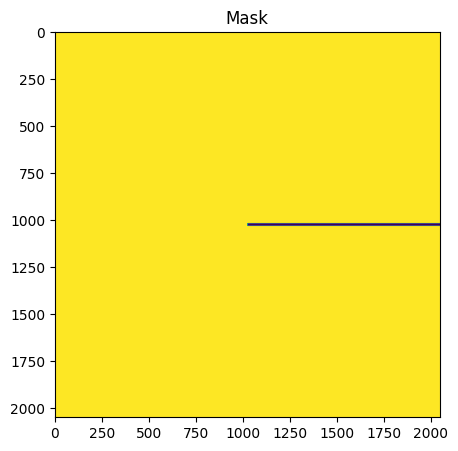

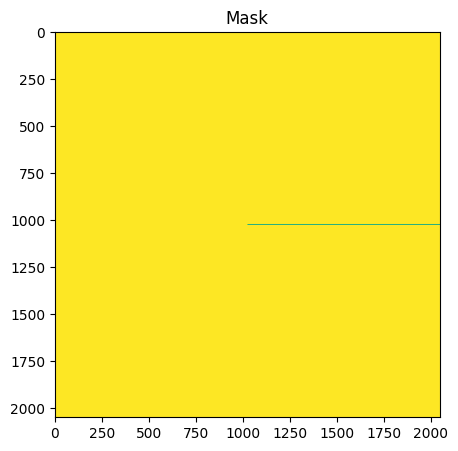

In [11]:
GST_6C_real_0035 = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\p21p1\gits_a_GST_6C_real\gits_a_GST_6C_real_45_mdeg-00035.tif'
GST_6C_real_0035_image = imread(GST_6C_real_0035)
#check image
plt.imshow(GST_6C_real_0035_image, cmap = 'magma')
plt.show()
#create integration mask
mask_12 = create_mask_for_tiff(GST_6C_real_0035, 12)
mask_7 = create_mask_for_tiff(GST_6C_real_0035, 7)
mask_1 = create_mask_for_tiff(GST_6C_real_0035, 1)
#mask_05 = create_mask_for_tiff(GST_6C_real_0035, 0.5)

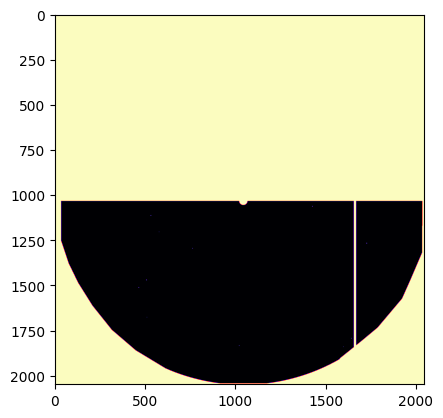

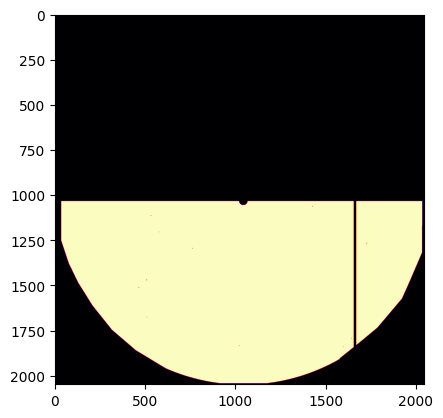

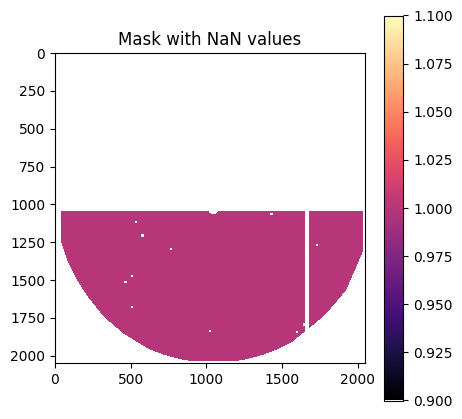

In [63]:
#load image mask
gz_mask_path = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\p21p1\Masks\mask_circle_edge_corrected.npy'
gz_mask = np.load(gz_mask_path)
plt.imshow(gz_mask, cmap = 'magma')
plt.show()
# Invert the mask (0s become 1s and 1s become 0s)
gz_inverted_mask = 1 - gz_mask  # or: np.logical_not(mask_12).astype(float)
#check mask
plt.imshow(gz_inverted_mask, cmap = 'magma')
plt.show()

# turned zeros to NaN in invertedpyfai mask
# Convert zeros to NaN
gz_mask_with_nan = gz_inverted_mask.astype(float)  # Convert to float type first since NaN requires float
gz_mask_with_nan[gz_inverted_mask == 0] = np.nan
# Visualize to verify
plt.figure(figsize=(5, 5))
plt.imshow(gz_mask_with_nan, cmap='magma')
plt.title('Mask with NaN values')
plt.colorbar()
plt.show()


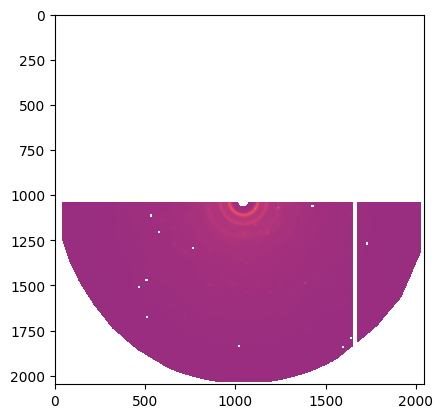

In [64]:
gz_combined_image = GST_6C_real_0035_image + gz_mask_with_nan
plt.imshow(gz_combined_image, cmap = 'magma')
plt.show()

C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_29380\3979555346.py:42: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(window)


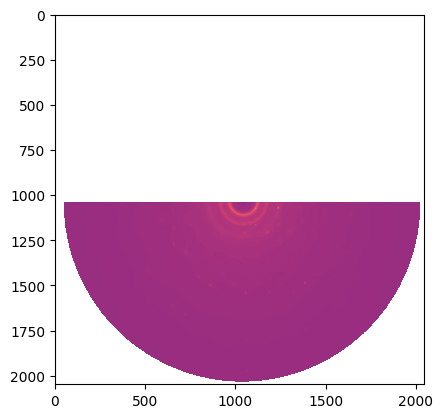

In [92]:
def fill_nan_with_neighbor_mean_circle(image, radius=None, center=None):
    """
    Fill NaN values with the mean of neighboring non-NaN pixels, but only within
    a circular region defined by radius and center
    
    Parameters:
    image: 2D numpy array
    radius: radius of circle (default: min(height,width)/2)
    center: (y,x) coordinates of circle center (default: image center)
    """
    # Create a copy of the image
    filled_image = np.copy(image)
    
    # Set defaults if not provided
    if center is None:
        center = (image.shape[0]//2, image.shape[1]//2)  # (y, x)
    if radius is None:
        radius = min(image.shape[0], image.shape[1])//2
        
    # Create a circular mask
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    dist_from_center = np.sqrt((y - center[0])**2 + (x - center[1])**2)
    circle_mask = dist_from_center <= radius
    
    # Find NaN pixels
    nan_y, nan_x = np.where(np.isnan(filled_image))
    
    # Loop through each NaN pixel
    for y, x in zip(nan_y, nan_x):
        # Check if this pixel is within the circle
        if circle_mask[y, x]:
            # Define a window around the NaN pixel (5x5 window)
            y_start = max(0, y - 2)
            y_end = min(image.shape[0], y + 3)
            x_start = max(0, x - 2)
            x_end = min(image.shape[1], x + 3)
            
            # Extract the window
            window = filled_image[y_start:y_end, x_start:x_end]
            
            # Calculate mean of non-NaN values in the window
            mean_value = np.nanmean(window)
            
            # Replace NaN with the calculated mean
            filled_image[y, x] = mean_value
            
    # Set all pixels outside circle to NaN
    filled_image[~circle_mask] = np.nan
    
    return filled_image


#tiff image = 2048x2048 pixels
gz_filled_with_mean = fill_nan_with_neighbor_mean_circle(gz_combined_image, radius = 992, center = (1048, 1035))
plt.imshow(gz_filled_with_mean, cmap = 'magma')
plt.show()

In [106]:
def apply_polarization(image, distance, center=None, polarization_factor=0.99):
    """
    Apply polarization correction to 2D diffraction image.
    
    Parameters:
        image (2D array): Raw diffraction image
        distance (float): Sample-to-detector distance in meters
        center (tuple): (x,y) beam center coordinates. If None, assumes center of image
        polarization_factor (float): Polarization factor, typically 0.99 for synchrotron
        
    Returns:
        2D array: Polarization-corrected image
    """
    import numpy as np
    
    # Get image dimensions and center if not provided
    ny, nx = image.shape
    if center is None:
        center = (nx//2, ny//2)
    
    # Create coordinate grid relative to beam center
    y, x = np.ogrid[:ny, :nx]
    y = y - center[1]
    x = x - center[0]
    
    # polar coordinates
    r = np.sqrt(x*x + y*y)
    phi = np.arctan2(y, x)
    
    # Calculate 2theta angle for each pixel
    pixel_size = 0.0002  #from poni file
    r_meters = r * pixel_size
    twotheta = np.arctan2(r_meters, distance)
    
    # Calculate polarization correction
    # For synchrotron radiation (horizontal polarization):
    P = (1 - polarization_factor * np.cos(phi)**2 * np.cos(twotheta)**2) / \
        (1 + np.cos(twotheta)**2)
    
    # Apply polarization correction
    corrected = image / P
    
    # Replace any invalid values with NaN
    corrected[~np.isfinite(corrected)] = np.nan
    
    return corrected

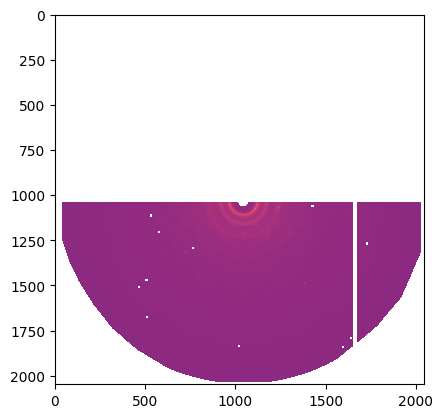

In [111]:
polarized_gz_image = apply_polarization(gz_combined_image, 0.40008, center=None, polarization_factor=0.1)
#check image
plt.imshow(polarized_gz_image, cmap = 'magma')
plt.show()

C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_29380\3979555346.py:42: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(window)


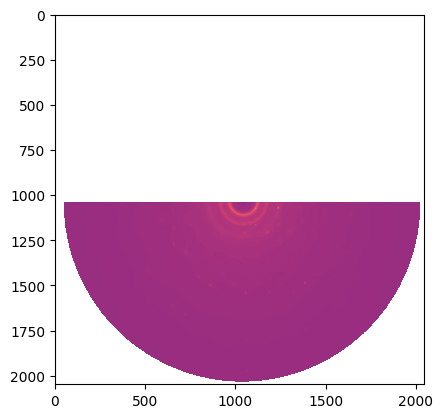

In [112]:
gz_filled_with_mean = fill_nan_with_neighbor_mean_circle(gz_combined_image, radius = 992, center = (1048, 1035))
plt.imshow(gz_filled_with_mean, cmap = 'magma')
plt.show()

In [79]:
def read_poni_file(poni_file):
    """
    This function reads a .poni file and extracts the distance and wavelength, rotation, and poni from the file.
    
    Parameters:
        poni_file (str): The path to the .poni file.
    """
    #read the .poni file and extract the distance and wavelength from the file
    with open(poni_file, 'r') as file:
        for line in file:
            if 'Distance:' in line:
                distance = float(line.split()[1])
            if 'Wavelength:' in line:
                wavelength = float(line.split()[1])
            if 'Rot1:' in line:
                rot1 = float(line.split()[1])
            if 'Rot2:' in line:
                rot2 = float(line.split()[1])
            if 'Rot3:' in line:
                rot3 = float(line.split()[1])
            if 'Poni1:' in line:
                poni1 = float(line.split()[1])
            if 'Poni2:' in line:
                poni2 = float(line.split()[1])
    
    return distance, wavelength, rot1, rot2, rot3, poni1, poni2

poni_file = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\p21p1\Calibrant\Ni_calib_400mm.poni'

In [127]:
#Create a function that takes the combined image and integrates it using the azimuthal integrator and displays the 1D image
def integrate_image(combined_image, distance, wavelength, resolution = 3000, mask = None, show = False, radial_range = (0,15)):
    """
    This function integrates the combined image using the azimuthal integrator and displays the 1D image.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
    """
    #initialize the azimuthal integrator
    
     # Initialize the detector
    dete = pyFAI.detectors.Perkin()
    p1, p2, p3 = dete.calc_cartesian_positions()
    poni1 = read_poni_file(poni_file)[5]
    poni2 = read_poni_file(poni_file)[6]
    

    ai = AI.AzimuthalIntegrator(dist=distance, poni1=poni1, poni2=poni2, detector=dete, wavelength=wavelength)
    
    #integrate the combined image using the azimuthal integrator
    q, I = ai.integrate1d(combined_image, resolution, radial_range = radial_range, unit = 'q_A^-1', mask = mask)
    
    if show == True:
        #plot the 1D image
        plt.figure(figsize=(10, 10))
        plt.plot(q, I)
        plt.title("1D X-Ray Diffraction Image")
        plt.show()
    
    return q, I

In [81]:
def image_rotation(image, angle, show = False):
    """
    This function rotates the combined image by a user specified angle amount, if the angle specified is 1, the result is that the combined image is rotated by one degree.
    
    Parameters:
        image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        """
    pil_format = Image.fromarray(image)
    rotated_image = pil_format.rotate(angle)
    rotated_image = np.array(rotated_image)
    
    if show == True:
        #display the rotated image
        plt.figure(figsize=(10, 10))
        plt.imshow(rotated_image, cmap='viridis')
        plt.title("Rotated Image")
        plt.show()
    return rotated_image

In [154]:
def rotate_and_integrate(combined_image, angle_of_rotation, distance, wavelength, resolution = 3000, mask = None):
    """
    This function takes the combined image, the mask, the distance, the wavelength, and the resolution of integration, and rotates the combined image by a user specified angle amount, if the angle specified is 1, the result will be 360 integrations of the combined image, each integration will be rotated by 1 degree.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        distance (float): The distance from the detector to the sample.
        wavelength (float): The wavelength of the x-rays.
        resolution (int): The resolution of the integration.
        mask (2D array): The mask to use for the integration.
    """
    
    import pandas as pd 
    
    #create a dataframe to store the 1D integrations
    df = pd.DataFrame()
    
    # Calculate number of steps for 180 degrees
    n_steps = int(180 / angle_of_rotation)
    angles = np.linspace(0, 180, n_steps, endpoint=False)

    # Pre-allocate lists to store data
    intensity_data = []
    angle_labels = []
    
    # Create a loop that rotates the combined image
    for i, angle in enumerate(angles):
        # Rotate the image
        rotated_image = image_rotation(combined_image, angle)
        
        # Integrate the rotated image
        q, I = integrate_image(rotated_image, distance, wavelength, resolution, mask, show=False)
        
        # Add the 1D integration to the dataframe
        # Store data
        intensity_data.append(I)
        angle_labels.append(f"{angle:.3f}")
                # Display rotated mask every 10 iterations if mask exists
        if mask is not None and i % 10 == 0:
            rotated = image_rotation(combined_image, angle)
            #print(f"Angle: {angle:.3f}, Intensity: {I}")
            # Calculate and print average value (excluding zeros and NaN)
            valid_pixels = rotated[rotated > 0]
            avg_value = np.nanmean(valid_pixels)
            print(f"Angle: {angle:.1f}°, Average Intensity: {avg_value:.2e}")
            rotated = image_rotation(combined_image, angle)
            plt.figure(figsize=(5, 5))
            plt.imshow(rotated, cmap='magma')
            plt.colorbar()
            plt.title(f'Tiff at {angle:.1f}°')
            plt.show()
            plt.close()

    
    # Create DataFrame all at once
    df = pd.DataFrame(np.array(intensity_data).T, columns=angle_labels)

    # Normalize x-axis (q values)
    q_normalized = (q - np.min(q)) / (np.max(q) - np.min(q))

    ## average tiff of rotations
    avg_tiff = np.mean(df, axis = 1)
    plt.figure(figsize=(10, 10))
    plt.plot(q, avg_tiff)
    plt.title("Average TIFF of Rotations")
    plt.show()

    # debugging statements
    # Add these diagnostic prints to your function before plotting:
    print(f"Original q range: [{np.min(q):.4f}, {np.max(q):.4f}]")
    print(f"Normalized q range: [{np.min(q_normalized):.4f}, {np.max(q_normalized):.4f}]")

    # You could also look at the first few values:
    print("\nFirst few q values:")
    print("Original:", q[:5])
    print("Normalized:", q_normalized[:5])  
        
    #create a waterfall plot of the 1D integrations, where each dataset is moved up on the y axis by a multiple of .5

    #plt.figure(figsize=(10, 10))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot using angles array instead of range()
    for angle in angles[1:len(angles)-1]:  # Skip first & last angles
        ax1.plot(q, (df[f"{angle:.3f}"]), c='black')
    ax1.set_xlabel('Original q (A$^{-1}$)')
    ax1.set_ylabel('Intensity')
    ax1.set_title("Original Scale")
    #ax1.show()        

    #create secondary plot with normalized q values
    #plt.figure(figsize=(10, 10))
    
    # Plot using angles array with normalized x-axis
    for angle in angles[1:len(angles)-1]:  # Skip first & last angles
        ax2.plot(q_normalized, (df[f"{angle:.3f}"]), c='black')
    ax2.set_xlabel('Normalized q')
    ax2.set_ylabel('Intensity')
    ax2.set_title("Normalized Scale")
    # Add original q values on a secondary x-axis

    #ax2 = plt.gca().twiny()
    #ax2.set_xlim(np.min(q), np.max(q))
    #ax2.set_xlabel('q A$^{-1}$')
    plt.tight_layout()
    plt.show()
    return q, df, avg_tiff

Angle: 0.0°, Average Intensity: 3.12e+04


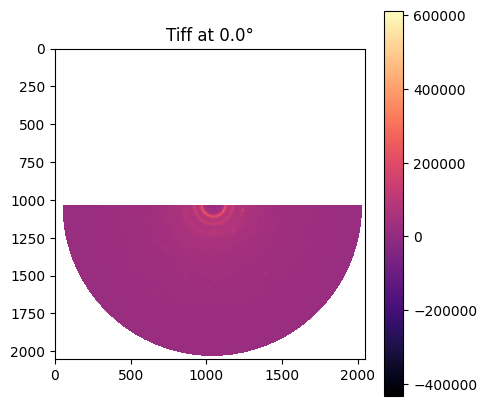

Angle: 50.0°, Average Intensity: 3.12e+04


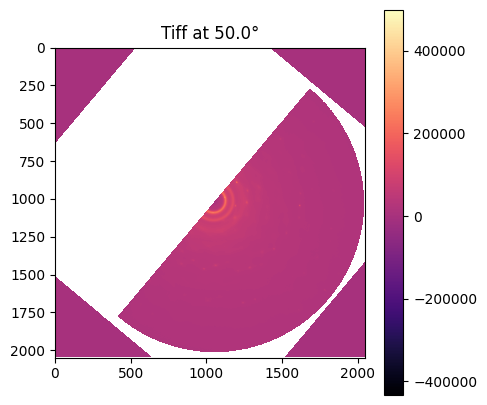

Angle: 100.0°, Average Intensity: 3.12e+04


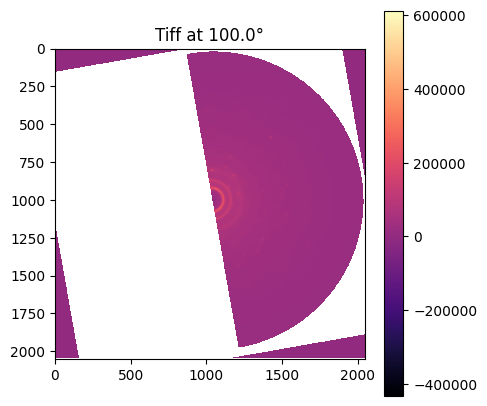

Angle: 150.0°, Average Intensity: 3.12e+04


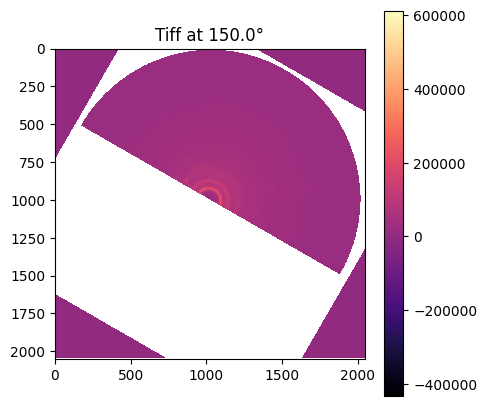

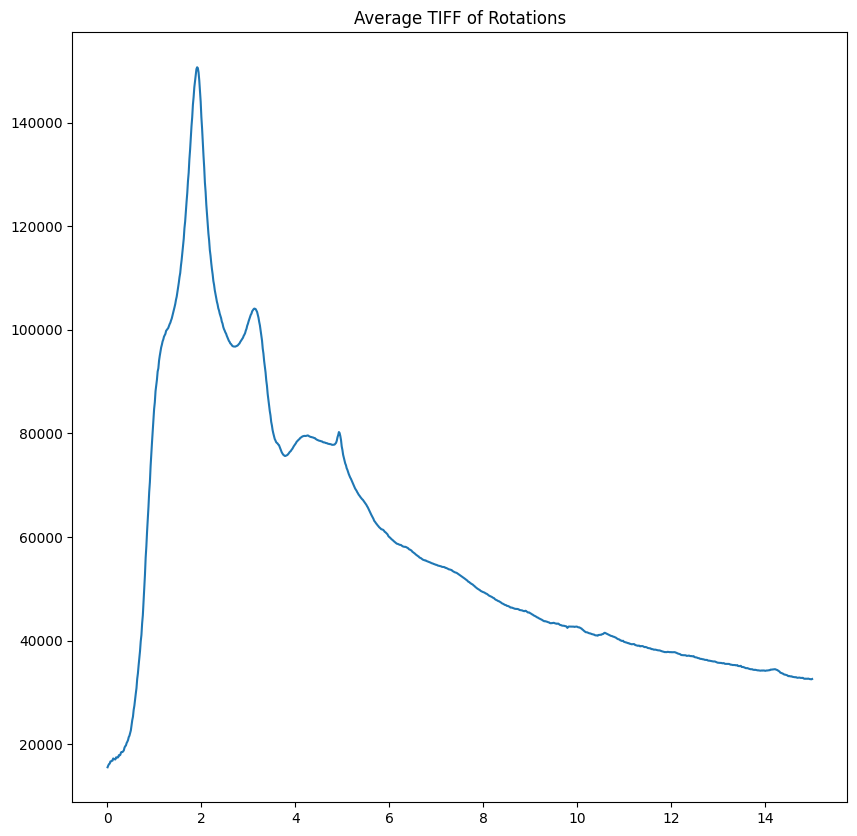

Original q range: [0.0075, 14.9925]
Normalized q range: [0.0000, 1.0000]

First few q values:
Original: [0.0075     0.0225     0.0375     0.05250001 0.06750001]
Normalized: [0.       0.001001 0.002002 0.003003 0.004004]


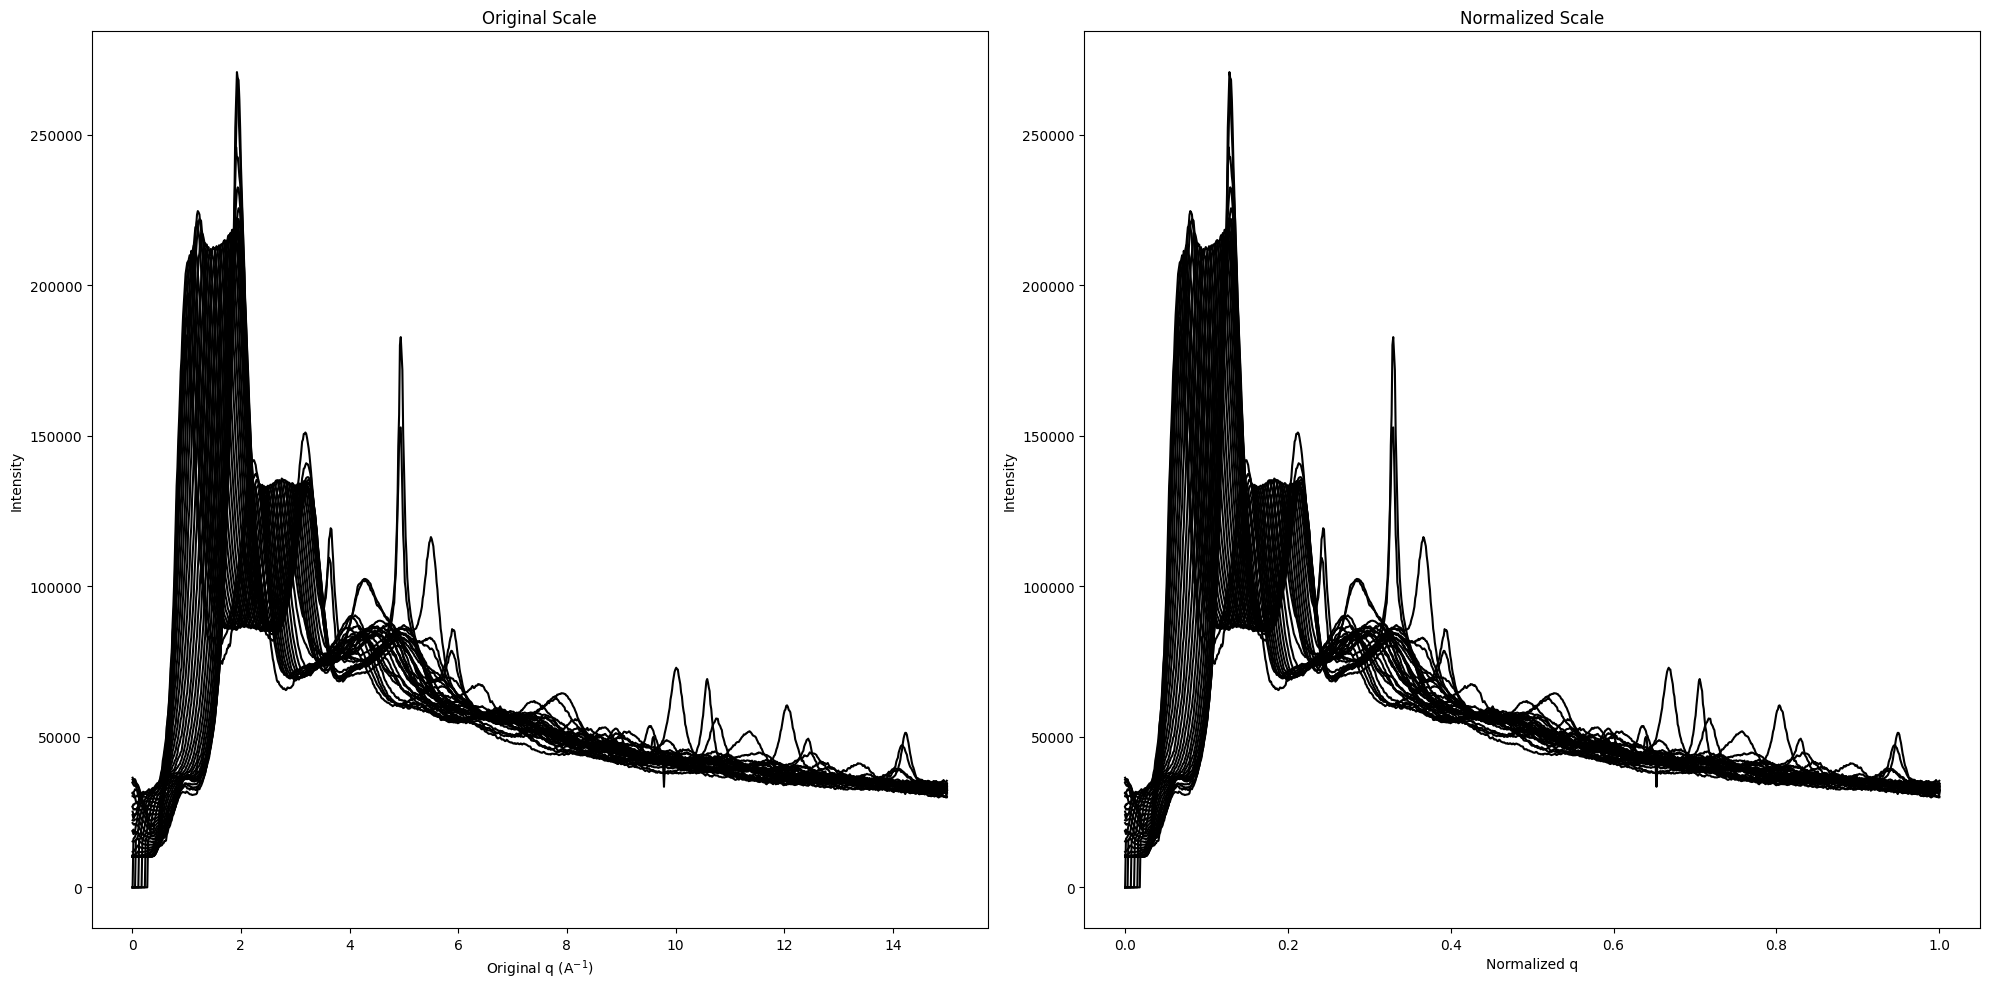

In [156]:
q, GST_6C_real_0035_nanmean_mask12, avg_tiff = rotate_and_integrate(gz_filled_with_mean, 5.0, .40008, 1.22212e-11, resolution = 1000, mask = mask_12)


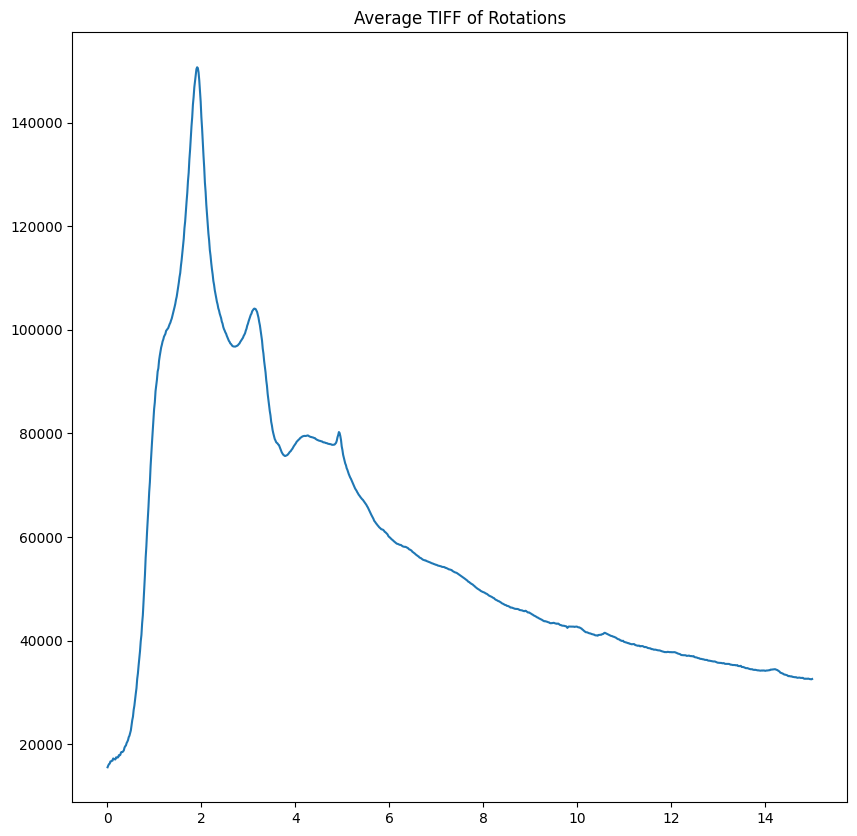

In [158]:
plt.figure(figsize=(10, 10))
plt.plot(q, avg_tiff)
plt.title("Average TIFF of Rotations")
plt.show()

Available columns: ['q_A^-1', 'intensity']

First few rows of data:
     q_A^-1  intensity
0  0.583367   18587.61
1  0.606613   19665.52
2  0.629858   20318.97
3  0.653104   20709.86
4  0.676350   21831.48


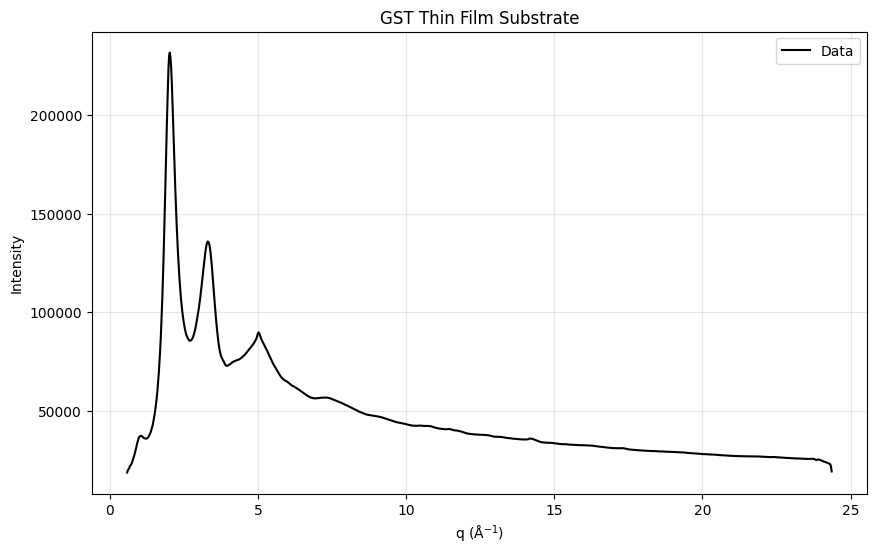


Basic statistics:
            q_A^-1      intensity
count  1024.000000    1024.000000
mean     12.473544   47744.513066
std       6.874862   30257.302672
min       0.583367   18587.610000
25%       6.528455   29212.120000
50%      12.473545   36727.070000
75%      18.418633   55741.057500
max      24.363720  231770.000000


In [141]:
# Load the CSV file
man_azi_df = pd.read_csv('C:/Users/kelleymarisa/UFL Dropbox/Marisa Kelley/DNA&MDKShare/copy_data_isodat/isodat_data/GST_thinfilm_substrate_manualazi.csv', sep=';')

# Print column names to verify data
print("Available columns:", man_azi_df.columns.tolist())
print("\nFirst few rows of data:")
print(man_azi_df.head())

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(man_azi_df['q_A^-1'], man_azi_df['intensity'], 'k-', label='Data')  # 'k-' means black line

# Customize plot
plt.xlabel('q (Å$^{-1}$)')
plt.ylabel('Intensity')
plt.title('GST Thin Film Substrate')
plt.grid(True, alpha=0.3)

plt.legend()

# Show plot
plt.show()

# Optional: print some basic statistics
print("\nBasic statistics:")
print(man_azi_df.describe())

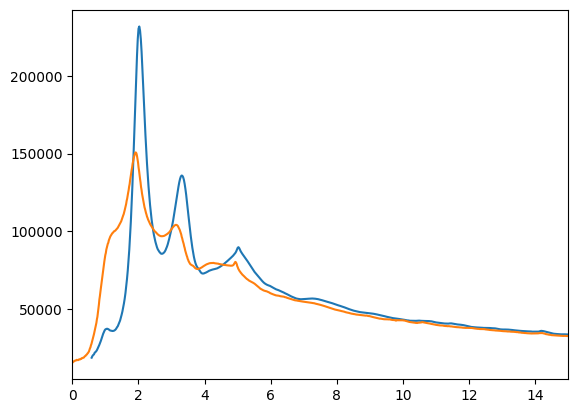

In [163]:
plt.plot(man_azi_df['q_A^-1'], man_azi_df['intensity'], label='Data')
plt.plot(q, avg_tiff, label='Data')
plt.xlim(0,15)
plt.show()

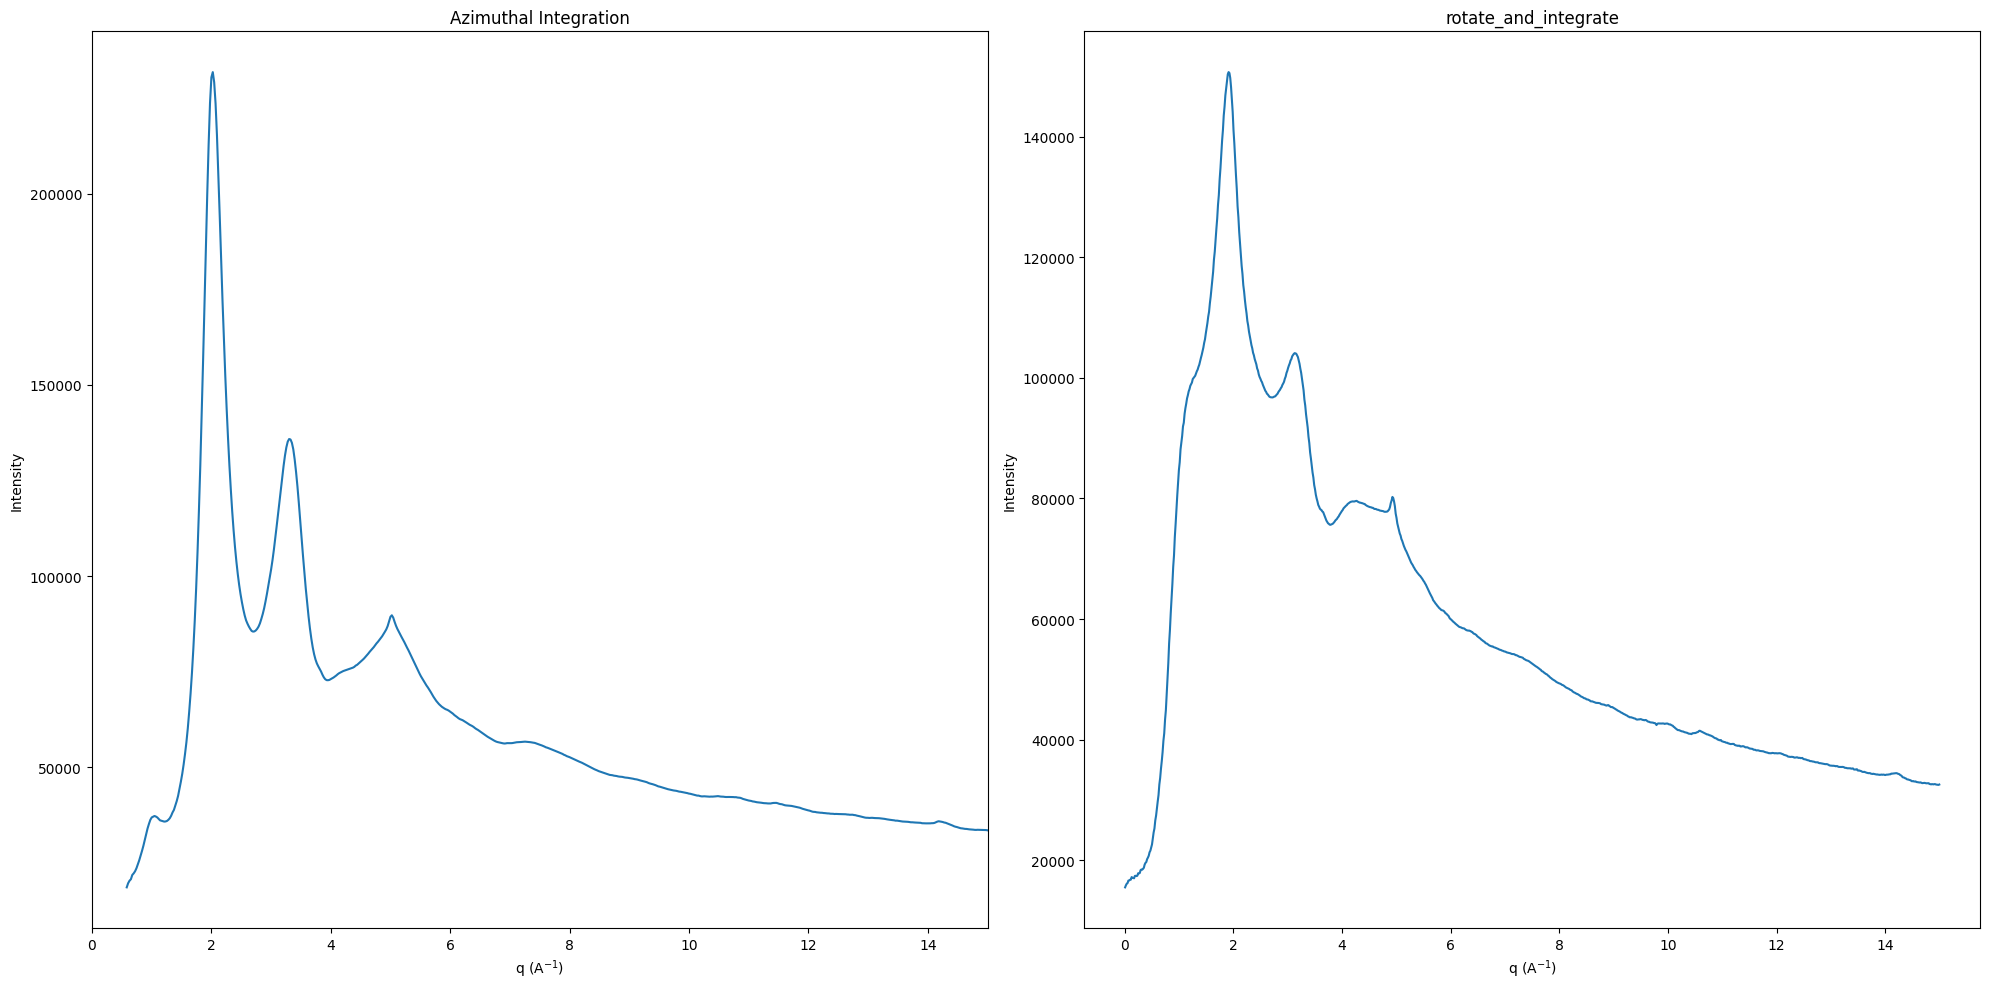

In [162]:
# Create DataFrame from avg_tiff data
avg_tiff_df = pd.DataFrame({
    'q': q,
    'intensity': avg_tiff
})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(man_azi_df['q_A^-1'], man_azi_df['intensity'], label='Data')
ax1.set_xlabel('q (A$^{-1}$)')
ax1.set_xlim(0,15)
ax1.set_ylabel('Intensity')

ax1.set_title("Azimuthal Integration")

ax2.plot(avg_tiff_df['q'], avg_tiff_df['intensity'], label='Data')
ax2.set_xlabel('q (A$^{-1}$)')
ax2.set_ylabel('Intensity')
ax2.set_title("rotate_and_integrate") 

plt.tight_layout()
plt.show()


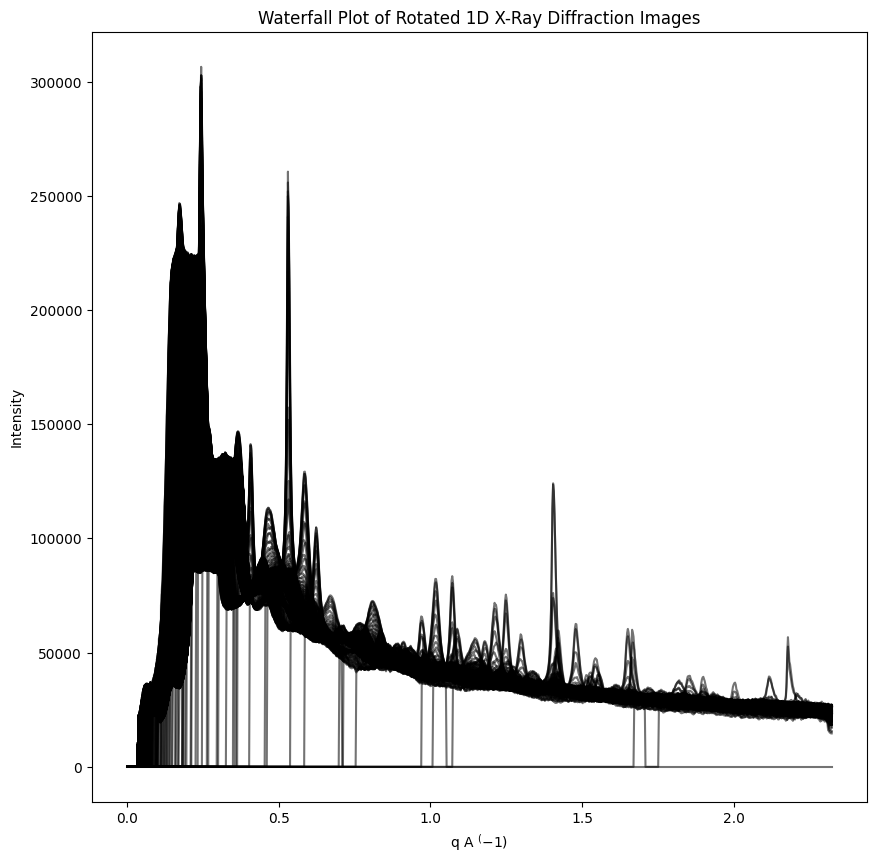

In [58]:
q, GST_6C_real_0035_nanmean_mask7 = rotate_and_integrate(gz_filled_with_mean, 0.5, .40008, 1.22212e-11, resolution = 1000, mask = mask_7)


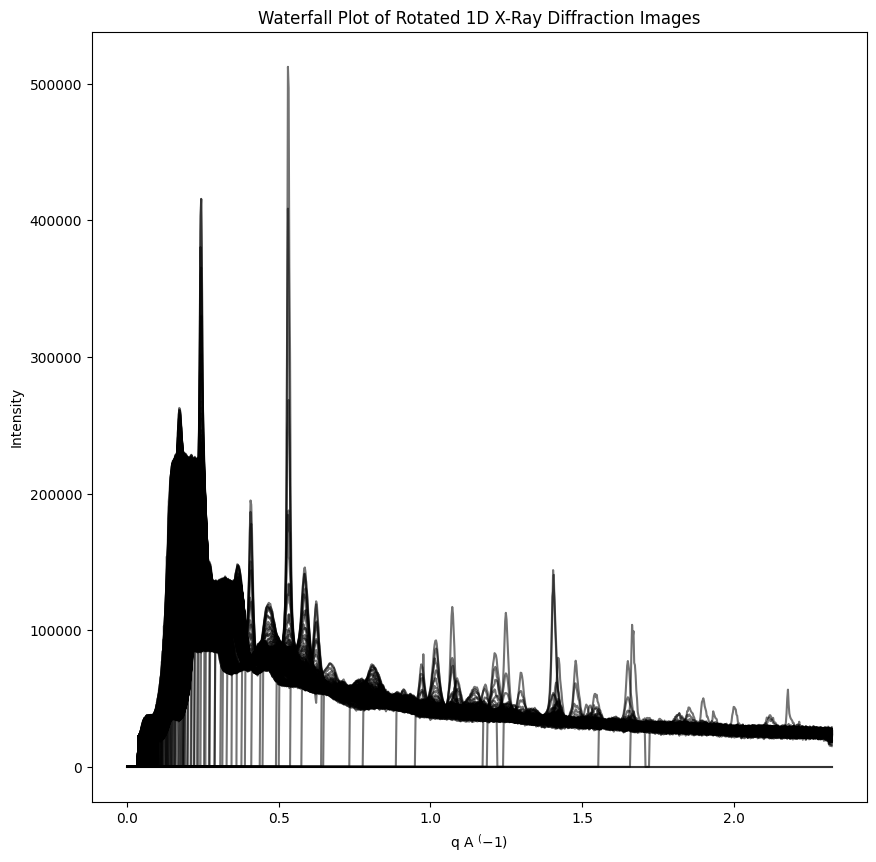

In [59]:
q, GST_6C_real_0035_nanmean_mask1 = rotate_and_integrate(gz_filled_with_mean, 0.5, .4179, 1.222e-10, resolution = 1000, mask = mask_1)

In [19]:
print("1D data range, mask 12:", np.min(GST_6C_real_0035_nanmean_mask12), "to", np.max(GST_6C_real_0035_nanmean_mask12))
GST_6C_real_0035_nanmean_mask12_clip = np.clip(GST_6C_real_0035_nanmean_mask12, 0, None)  # Clips to range [0, inf]
print("1D data range, mask 12:", np.min(GST_6C_real_0035_nanmean_mask12_clip), "to", np.max(GST_6C_real_0035_nanmean_mask12_clip))

1D data range, mask 12: 0.0 to 275972.06
1D data range, mask 12: 0.0 to 275972.06


In [20]:
print("1D data range, mask 7:", np.min(GST_6C_real_0035_nanmean_mask7), "to", np.max(GST_6C_real_0035_nanmean_mask7))
GST_6C_real_0035_nanmean_mask7_clip = np.clip(GST_6C_real_0035_nanmean_mask7, 0, None)  # Clips to range [0, inf]
print("1D data range, mask 7:", np.min(GST_6C_real_0035_nanmean_mask7_clip), "to", np.max(GST_6C_real_0035_nanmean_mask7_clip))

1D data range, mask 7: 0.0 to 306424.88
1D data range, mask 7: 0.0 to 306424.88


In [21]:
print("1D data range, mask 1:", np.min(GST_6C_real_0035_nanmean_mask1), "to", np.max(GST_6C_real_0035_nanmean_mask1))
GST_6C_real_0035_nanmean_mask1_clip = np.clip(GST_6C_real_0035_nanmean_mask1, 0, None)  # Clips to range [0, inf]
print("1D data range, mask 1:", np.min(GST_6C_real_0035_nanmean_mask1_clip), "to", np.max(GST_6C_real_0035_nanmean_mask1_clip))

1D data range, mask 1: 0.0 to 512406.9
1D data range, mask 1: 0.0 to 512406.9


Clustering & Dendrograms

The beta-divergence is:  505468640.0 %
 The final number of components used were 64 

Components shape: (1000, 63)


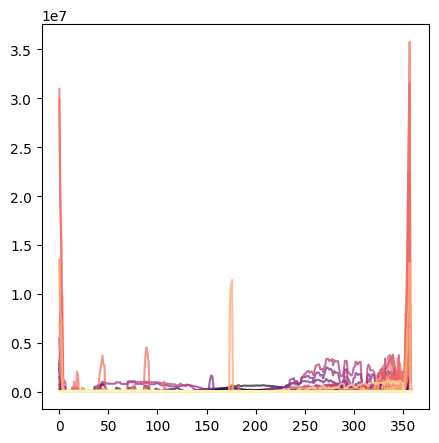

In [22]:
# Run NMF & HAC separately
# Mask 12 NMF
weights, components, beta = iso.Run_NMF(GST_6C_real_0035_nanmean_mask12, init=None, solver='cd', beta_loss='frobenius', itear=1000, show=True)

print(f"Components shape: {components.shape}")

In [23]:
def AggCluster(Number_Clusters, data):
    
    """A program that will take in the type of scikitlearn clustering algorithm
        desired and the number of clusters as well as the data in a numpy array
        and output the associated clusters with the original data. This will make
        the 'latent' space from the clustering algorithms have more meaning"""

    from sklearn.cluster import AgglomerativeClustering
    Make_Clusters= AgglomerativeClustering(n_clusters = Number_Clusters, compute_distances=True)
    y_kmeans = Make_Clusters.fit_predict(data)
    information = Make_Clusters.fit(data)
    parameter = information.distances_

    x = 0
    Understanding_data = {"Cluster_Number":[], "Int_Angle":[]};
    while x < len(data):
        Understanding_data["Cluster_Number"].append(y_kmeans[x])
        Understanding_data["Int_Angle"].append(data[x])
        x = x+1
        
    # Create an empty list to store the data
    data_list = []
    
        
    q = 0
    while q < Number_Clusters:
        z = 0
        plt.figure(figsize=(5,5))
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Agglomerative Clustering'+' ' +str(q))

        while z < len(data):
            if Understanding_data["Cluster_Number"][z] == q:
                plt.plot(Understanding_data["Int_Angle"][z], label = 'Component'+str(z))
            z = z+1
    
        # Check if the plot looks good if the plot looks good, append the data to the list
        plt.show(block = False)
        plt.pause(0.1)
        
        if input("Do the identified components look like an isotropic scattering signal?") == '':
            i = 0
            while i < len(data):
                if Understanding_data["Cluster_Number"][i] == q:
                    data_list.append(Understanding_data["Int_Angle"][i])
                i = i+1
                
        q = q+1
    
    return Understanding_data, data_list

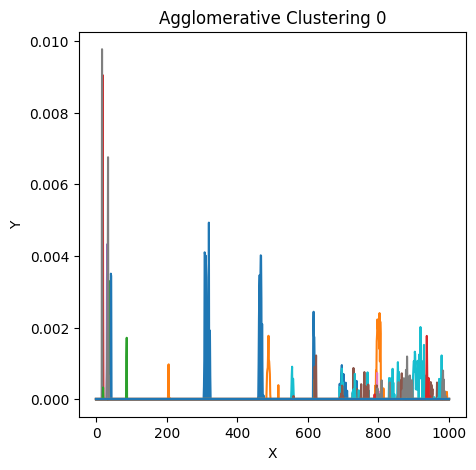

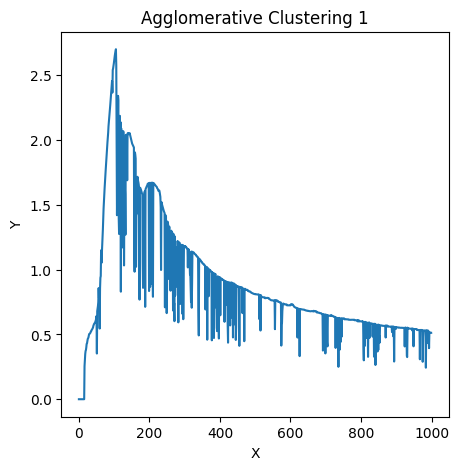

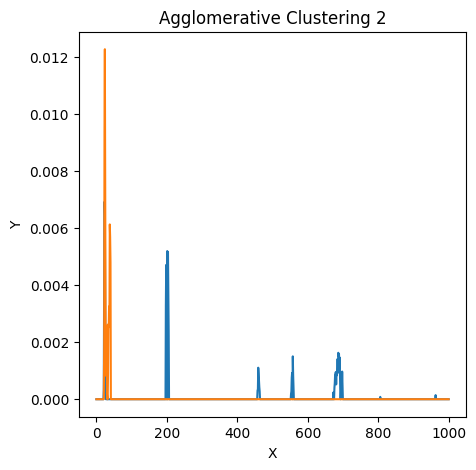

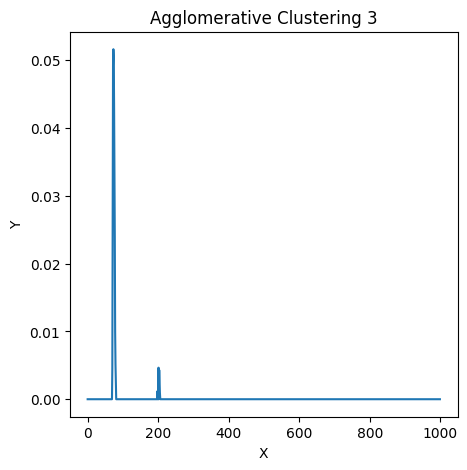

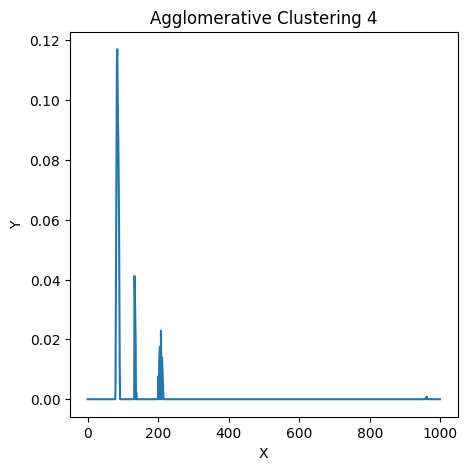

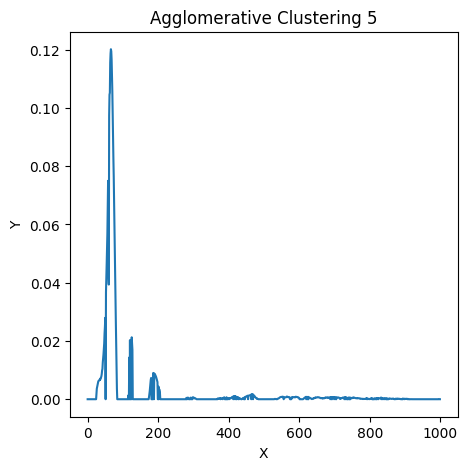

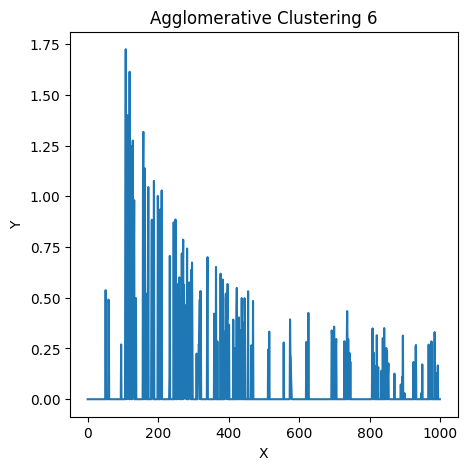

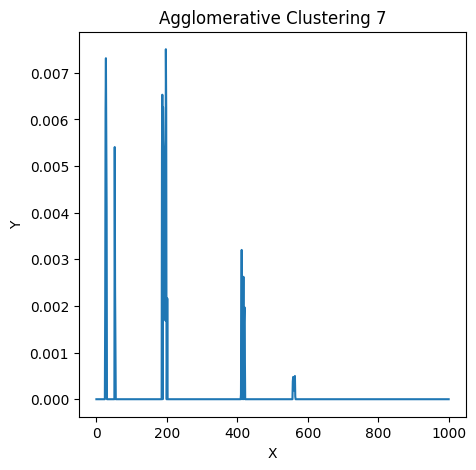

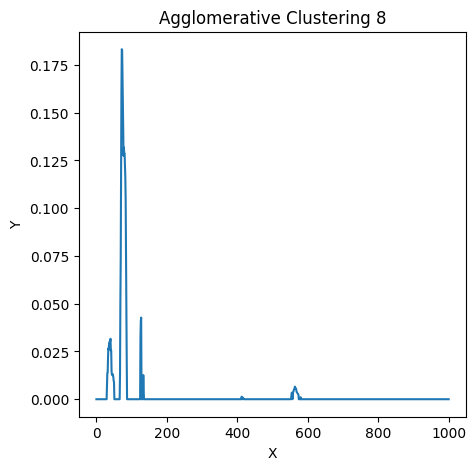

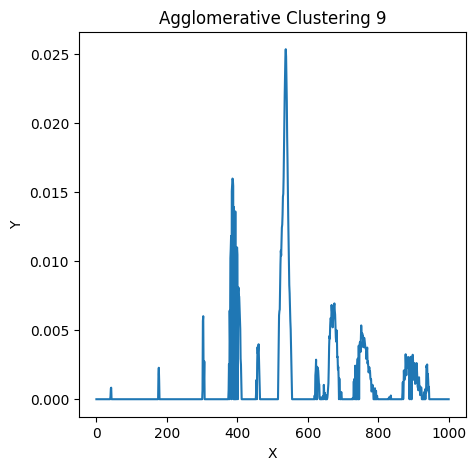

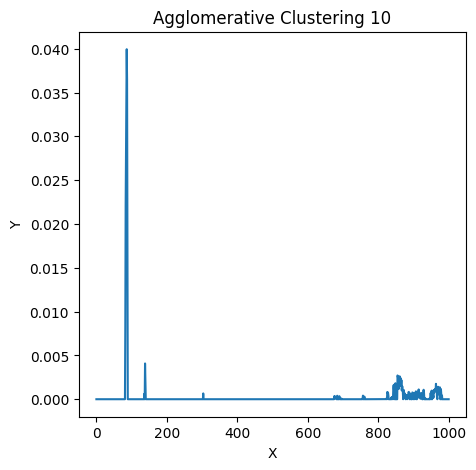

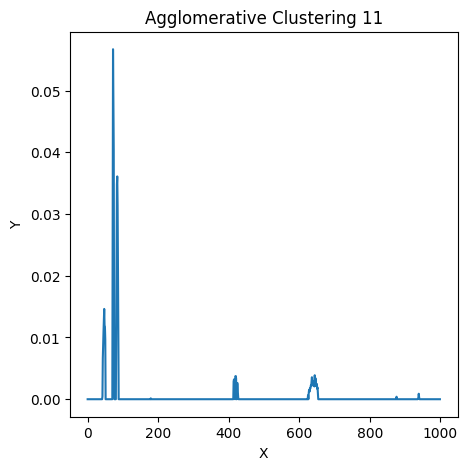

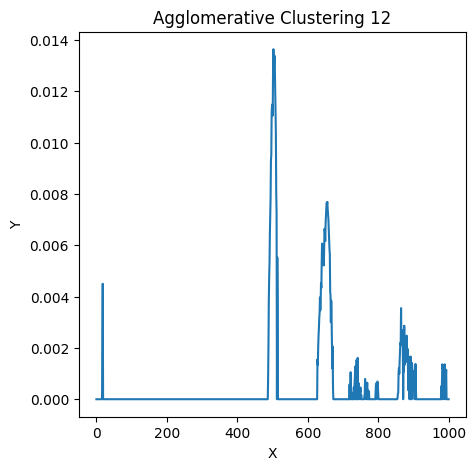

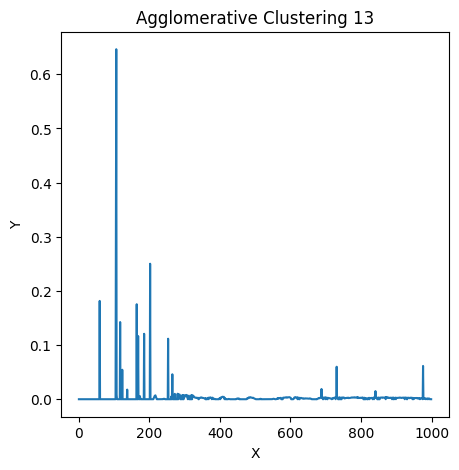

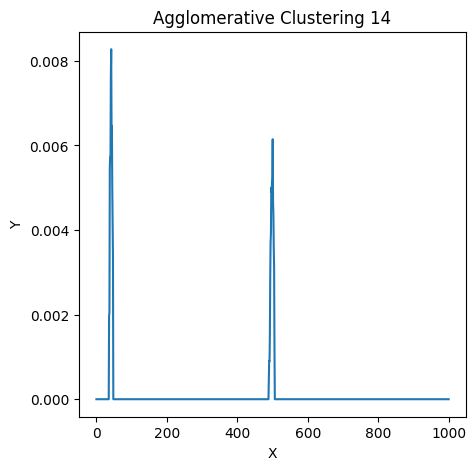

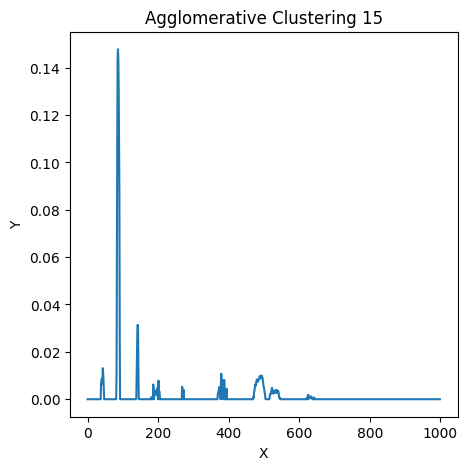

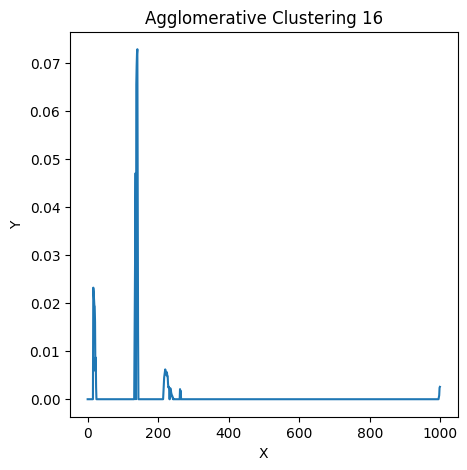

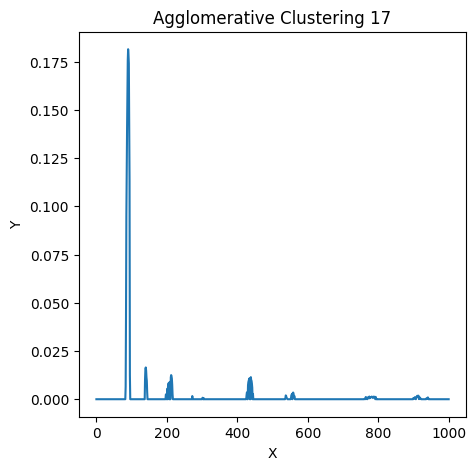

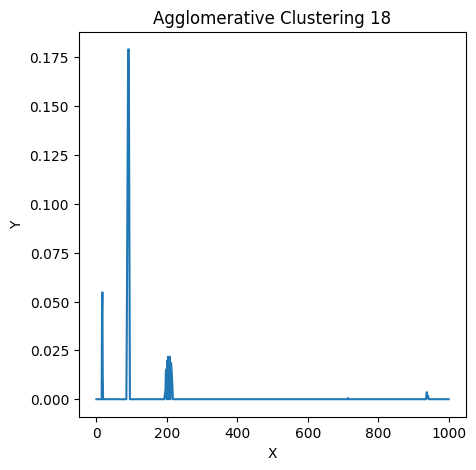

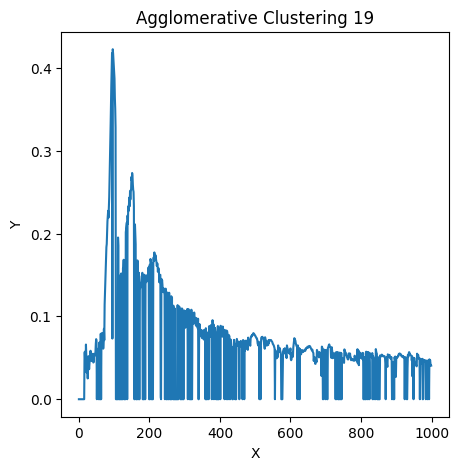

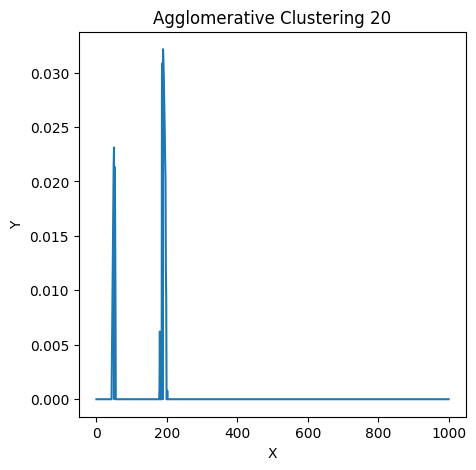

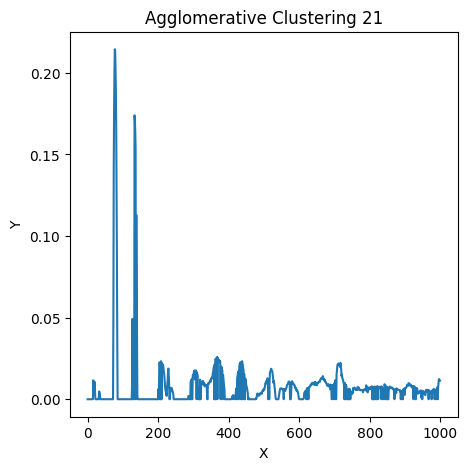

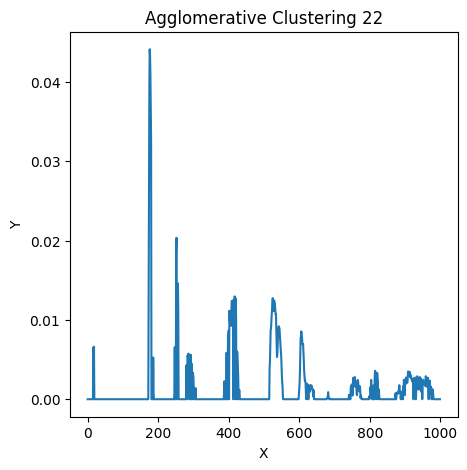

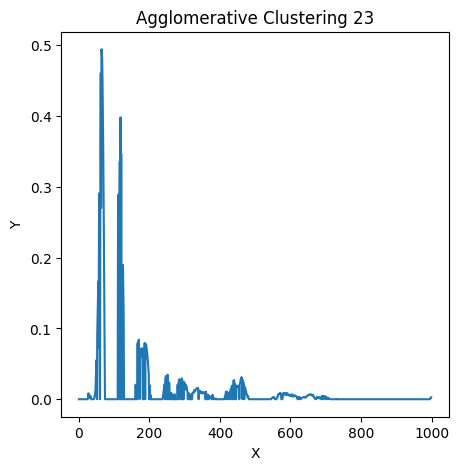

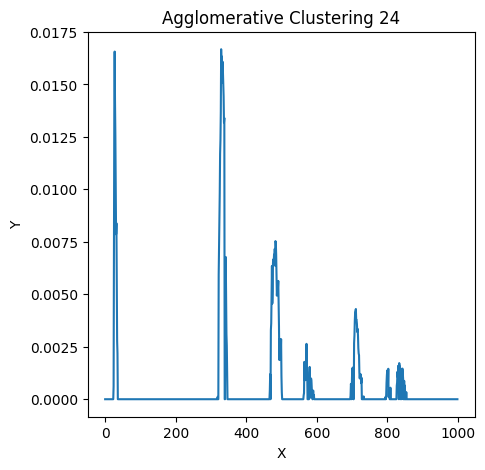

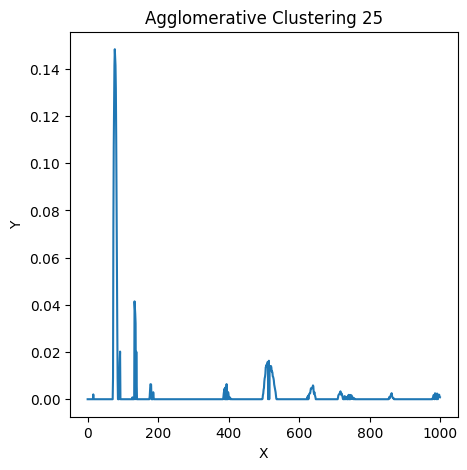

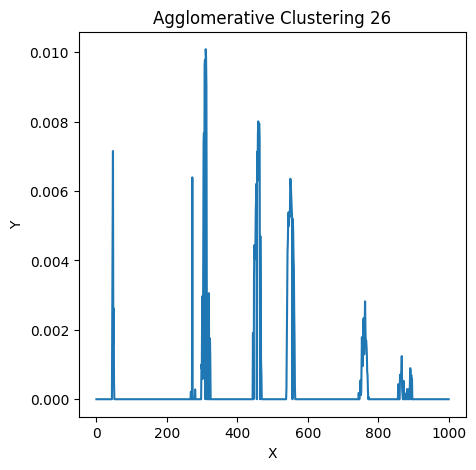

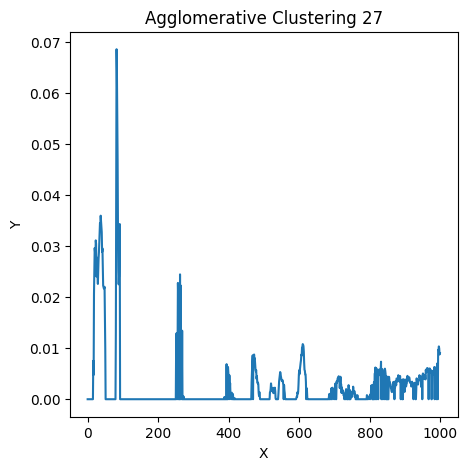

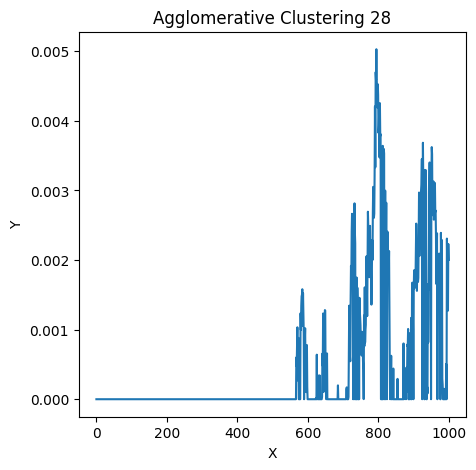

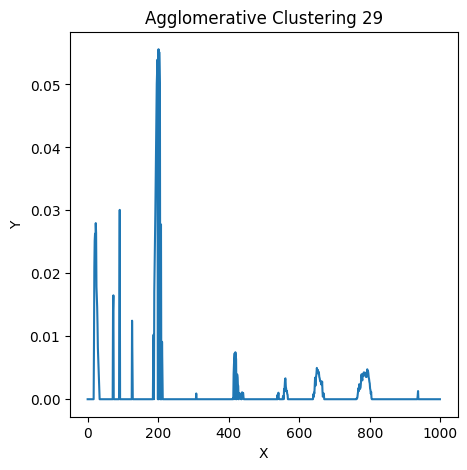

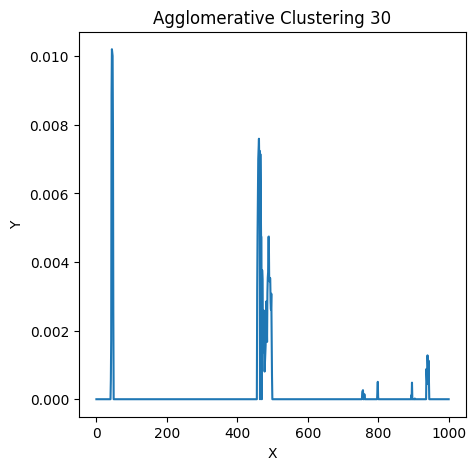

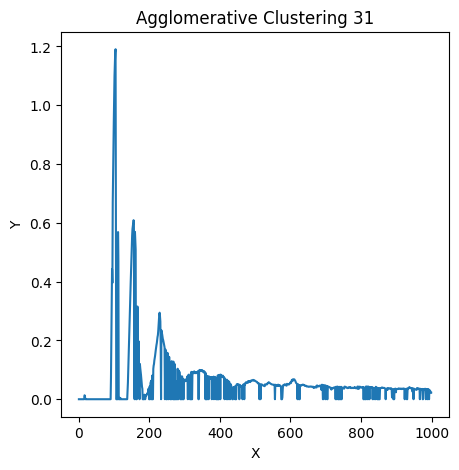

Number of components found: 63


In [24]:
#Mask 12 clustering
# Note: components needs to be transposed for AggCluster
AggComponents_12 = np.array(components).T
clusters = 32  # number of clusters you want
Understanding_data, found_compos_12 = AggCluster(clusters, AggComponents_12)

# found_compos identified components
print(f"Number of components found: {len(found_compos_12)}")

Data shape: (63, 1000)
NaN values: 0
Inf values: 0


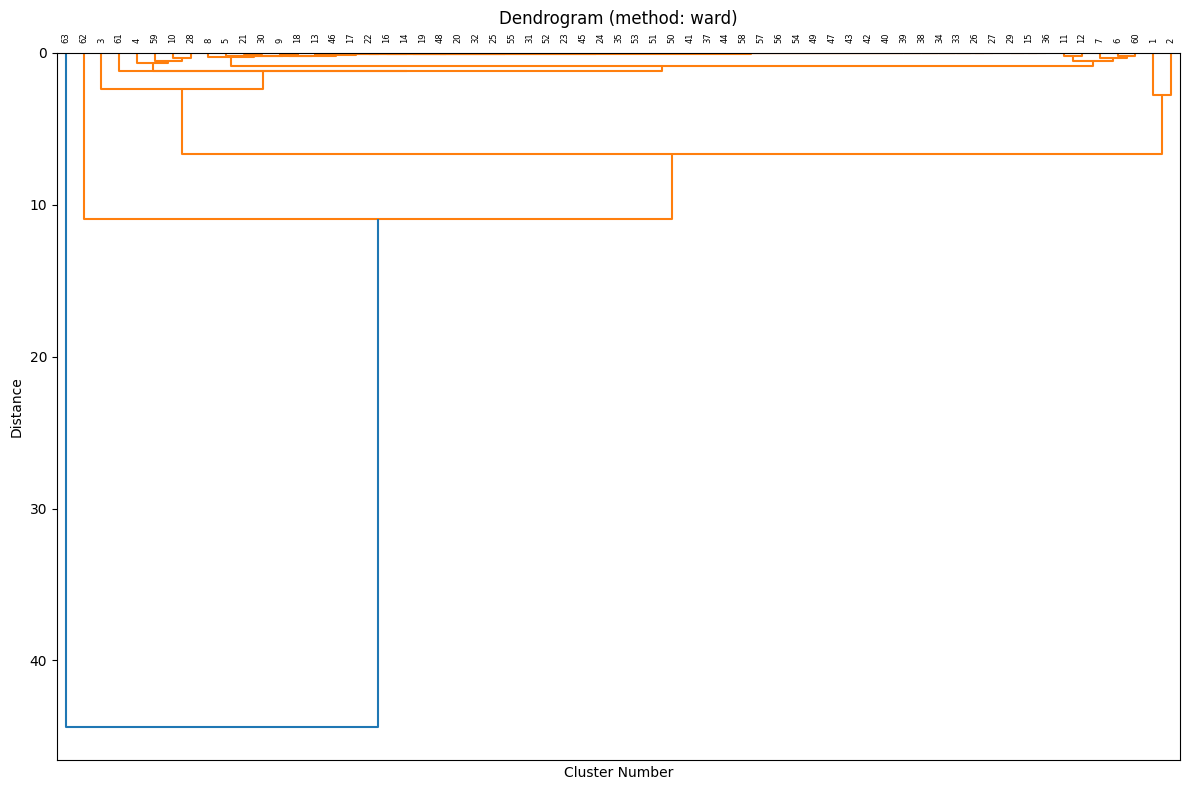

In [25]:
# Print dendrogram for mask 12
def plot_detailed_dendrogram(data, method='ward', figsize=(12, 8)):
    """
    Plot dendrogram with detailed information
    """
    # Print data shape and check for NaN/inf
    print("Data shape:", data.shape)
    print("NaN values:", np.isnan(data).sum())
    print("Inf values:", np.isinf(data).sum())
    
    # Compute linkage
    try:
        Z = linkage(data, method=method)
        
        plt.figure(figsize=figsize)
        dendrogram(Z,
                  labels=range(1, len(data) + 1),
                  orientation='bottom',
                  distance_sort='ascending',
                  leaf_rotation=90,
                  show_leaf_counts=True)  # Shows the number of original observations
        plt.title(f'Dendrogram (method: {method})')
        plt.xlabel('Cluster Number')
        plt.ylabel('Distance')
        plt.tight_layout()
        plt.show()
        
        return Z
    except Exception as e:
        print(f"Error creating dendrogram: {e}")
        return None

Z = plot_detailed_dendrogram(AggComponents_12)

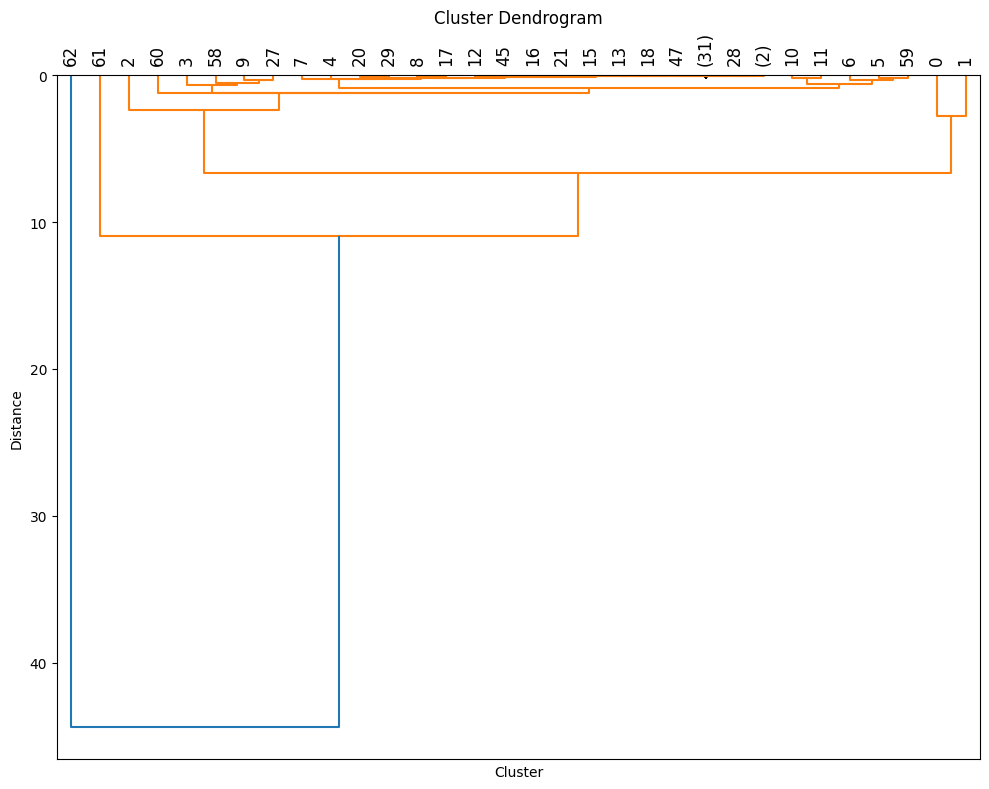

In [26]:
def plot_simple_dendrogram(data, n_clusters=10, figsize=(10, 8)):
    """
    Plot a simple dendrogram showing cluster relationships
    
    Parameters:
    data: The AggComponents data
    n_clusters: Number of clusters used in AggCluster
    """
    # Create linkage matrix
    Z = linkage(data, method='ward')
    plt.figure(figsize=figsize)
    dendrogram(Z,
              truncate_mode='lastp',  # Show only last p merged clusters
              p=32,           # Number of clusters to show
              leaf_rotation=90., 
              leaf_font_size=12., 
              show_contracted=True,
              orientation='bottom')
    
    # Clean up the plot
    plt.title('Cluster Dendrogram')
    plt.xlabel('Cluster')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

# Use it after running AggCluster:
# Understanding_data, found_compos = iso.AggCluster(n_clusters, AggComponents)
plot_simple_dendrogram(AggComponents_12, n_clusters=10)

The beta-divergence is:  510115800.0 %
 The final number of components used were 53 

Components shape: (1000, 52)


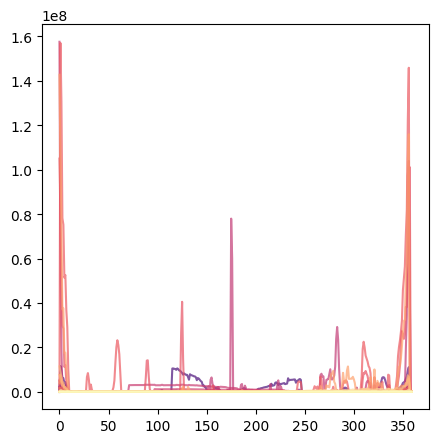

In [27]:
# Run NMF & HAC separately
# Mask 7 NMF
weights, components, beta = iso.Run_NMF(GST_6C_real_0035_nanmean_mask7_clip, init=None, solver='cd', beta_loss='frobenius', itear=1000, show=True)
print(f"Components shape: {components.shape}")

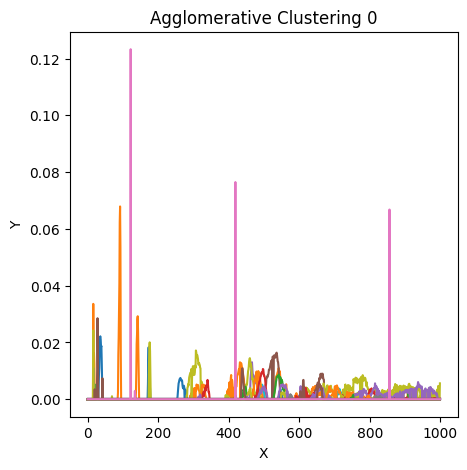

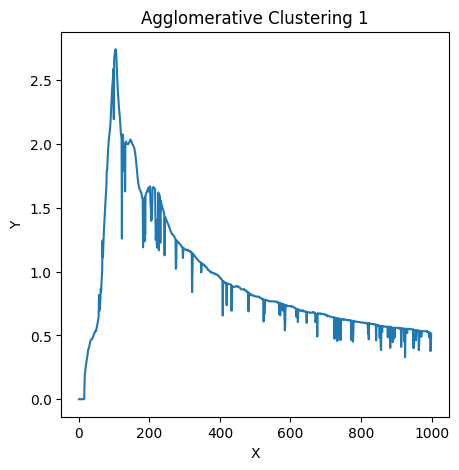

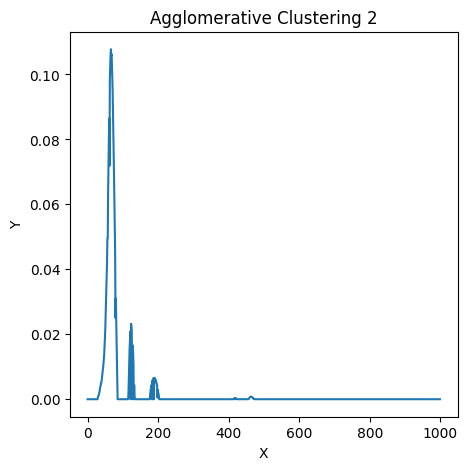

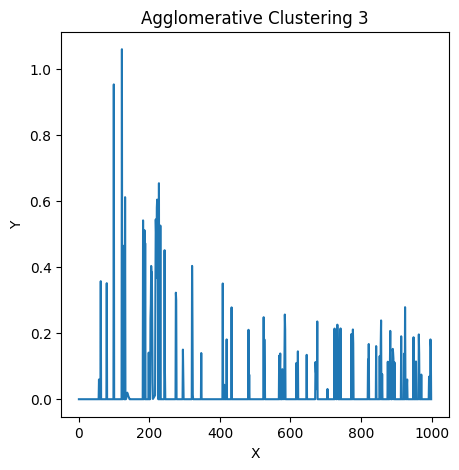

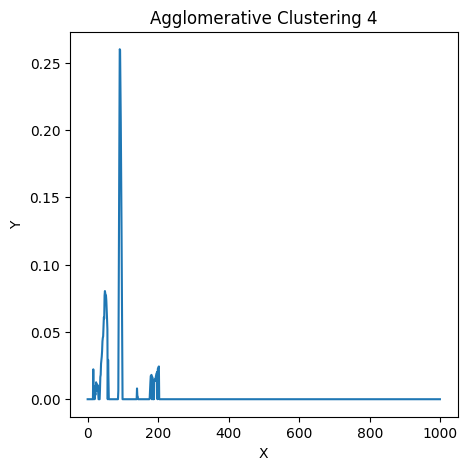

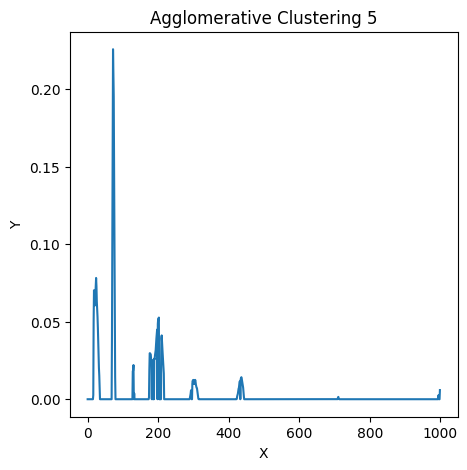

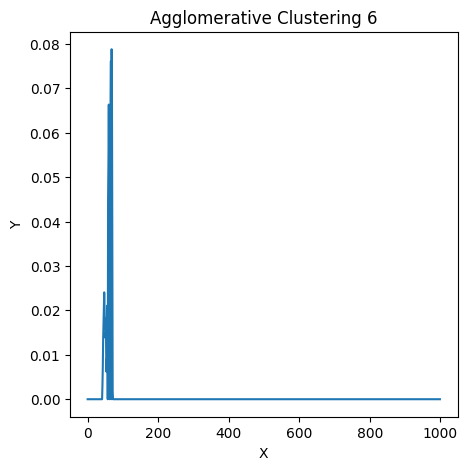

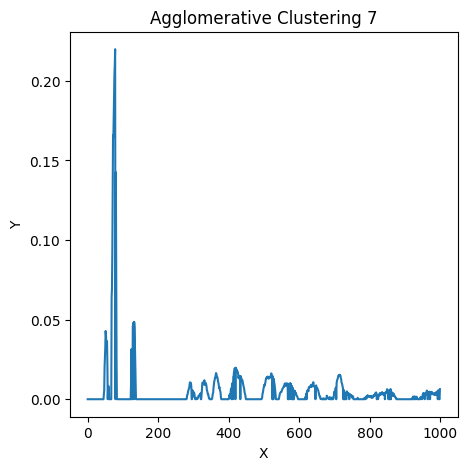

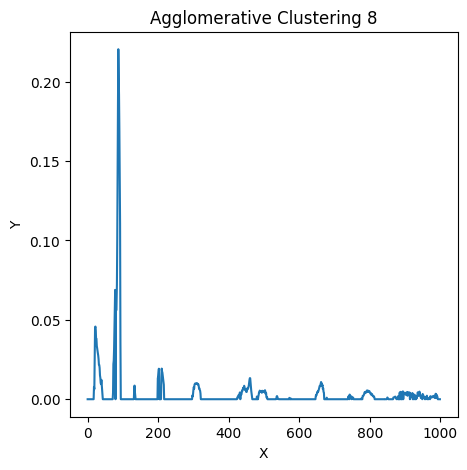

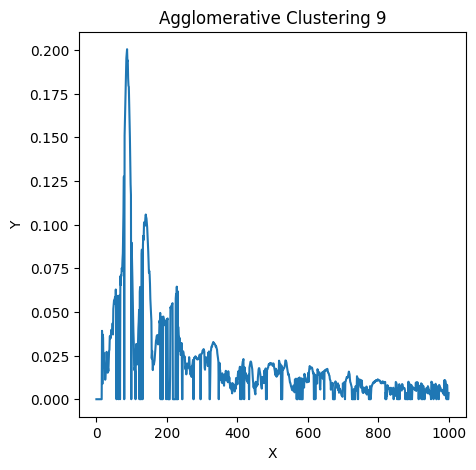

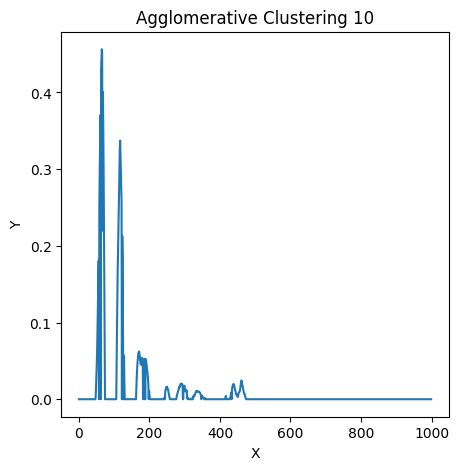

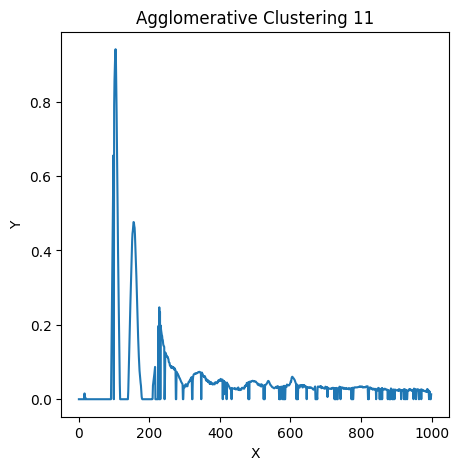

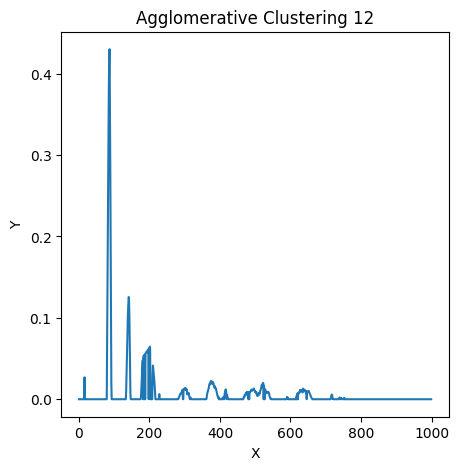

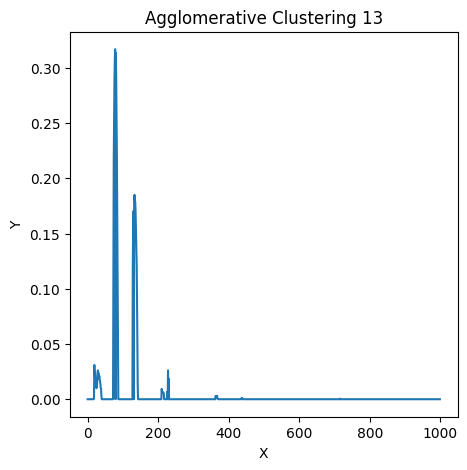

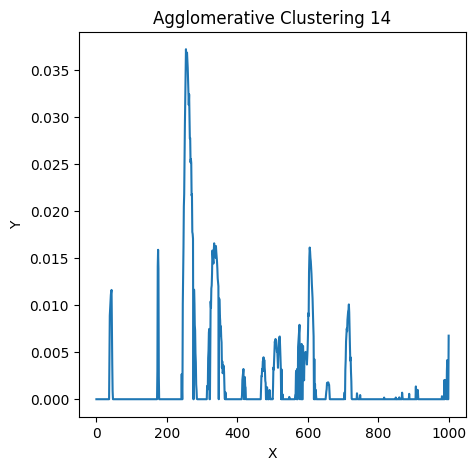

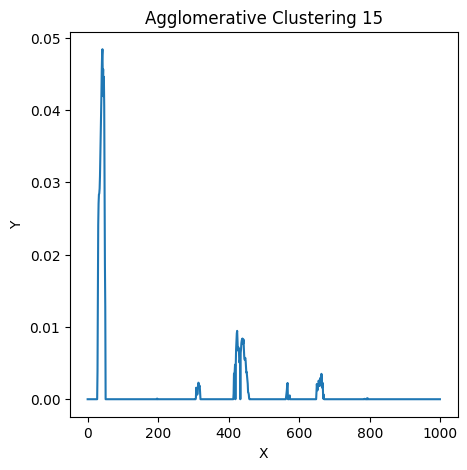

Number of components found: 52


In [28]:
#Mask 7 clustering
# Note: components needs to be transposed for AggCluster
AggComponents_7 = np.array(components).T
clusters = 16  # number of clusters you want
Understanding_data, found_compos_7 = AggCluster(clusters, AggComponents_7)

# found_compos identified components
print(f"Number of components found: {len(found_compos_7)}")

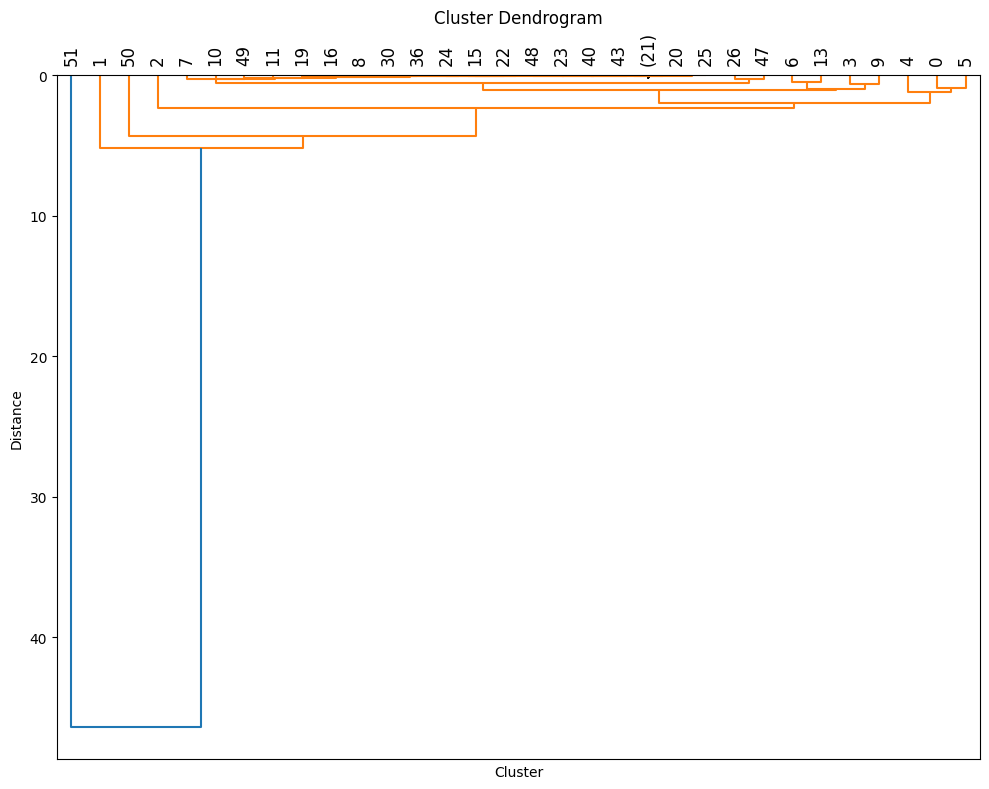

In [29]:
# Understanding_data, found_compos = iso.AggCluster(n_clusters, AggComponents)
plot_simple_dendrogram(AggComponents_7, n_clusters=16)

The beta-divergence is:  629241200.0 %
 The final number of components used were 84 

Components shape: (1000, 83)


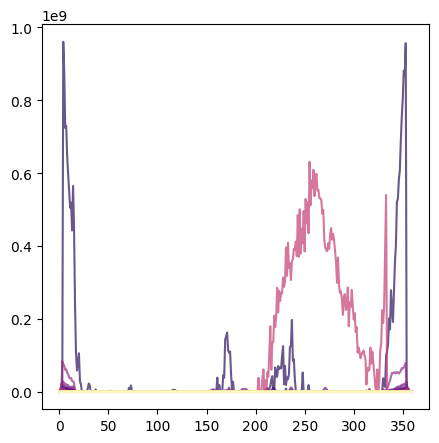

In [30]:
# Run NMF & HAC separately
# Mask 1 NMF
weights, components, beta = iso.Run_NMF(GST_6C_real_0035_nanmean_mask1_clip, init=None, solver='cd', beta_loss='frobenius', itear=1000, show=True)
print(f"Components shape: {components.shape}")

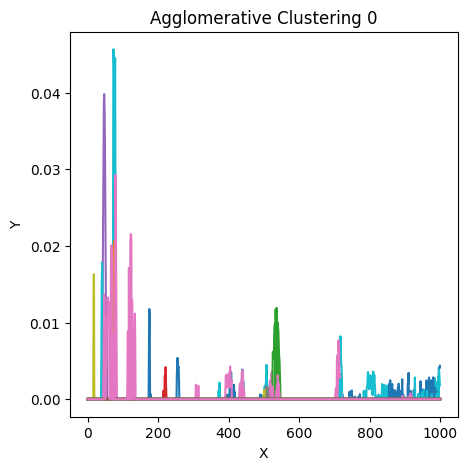

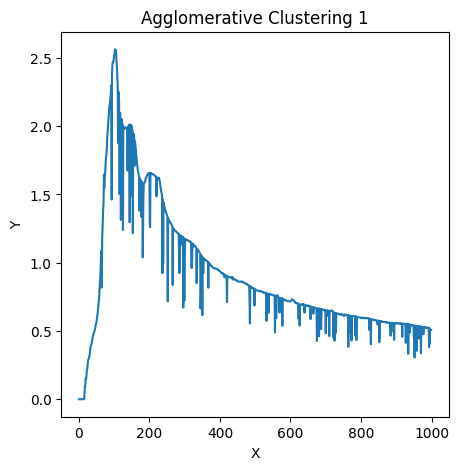

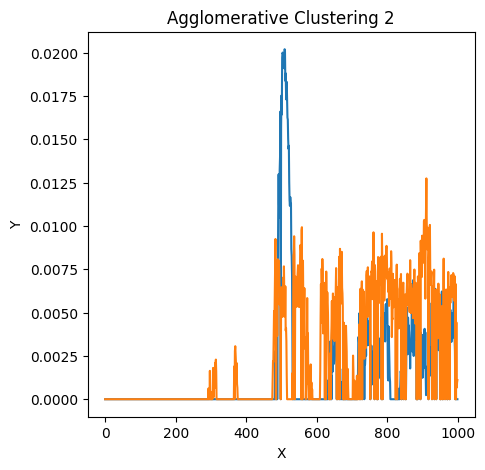

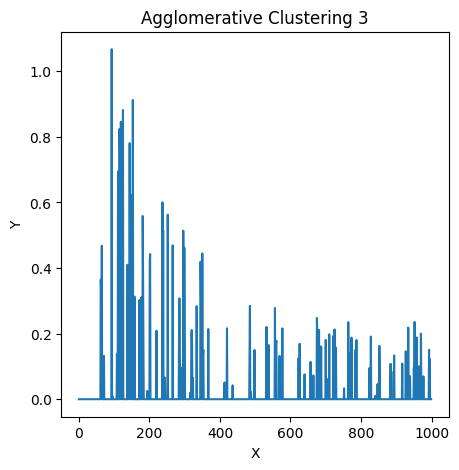

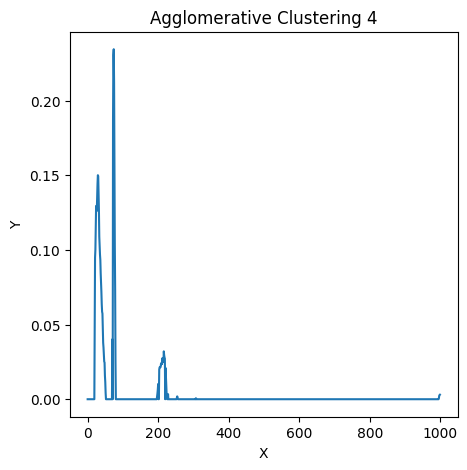

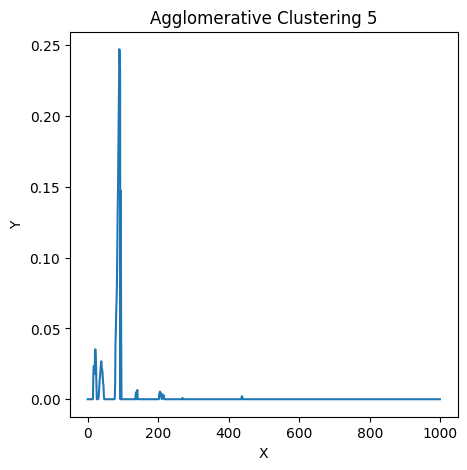

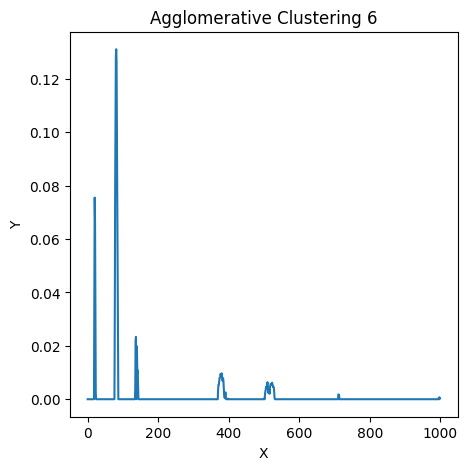

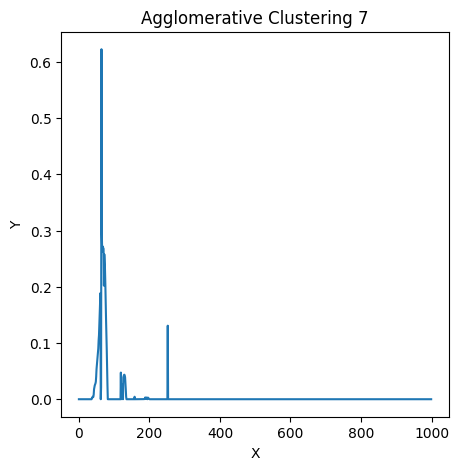

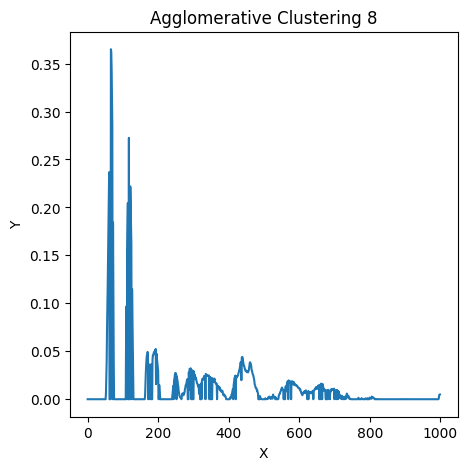

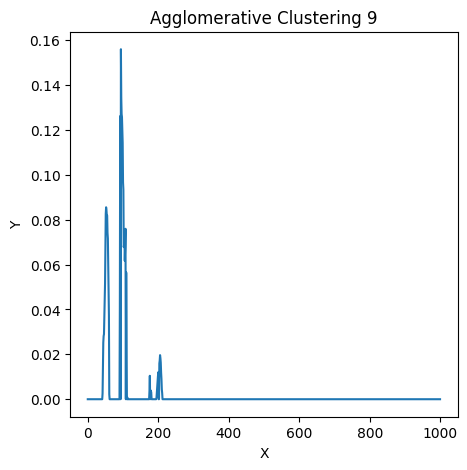

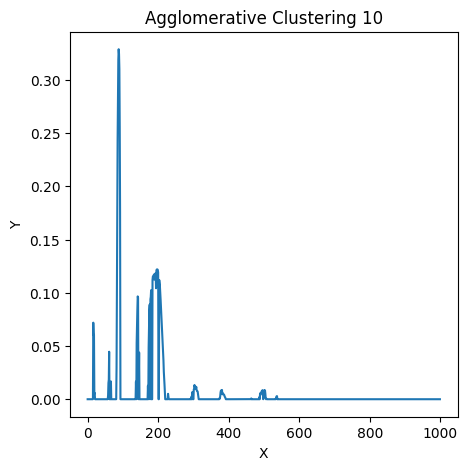

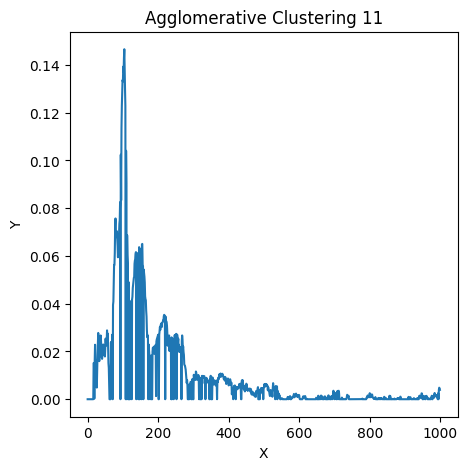

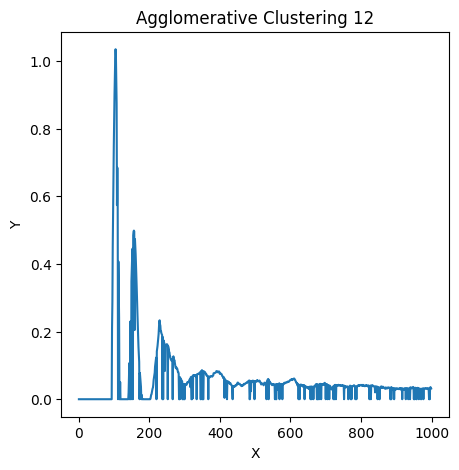

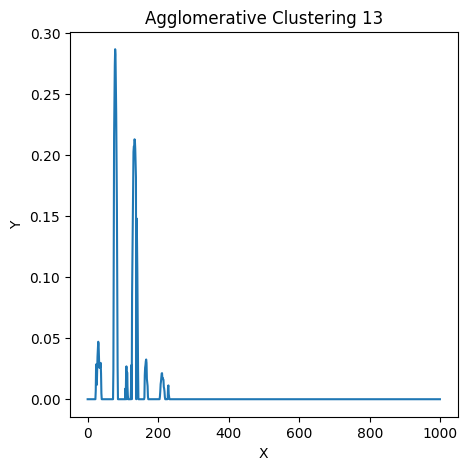

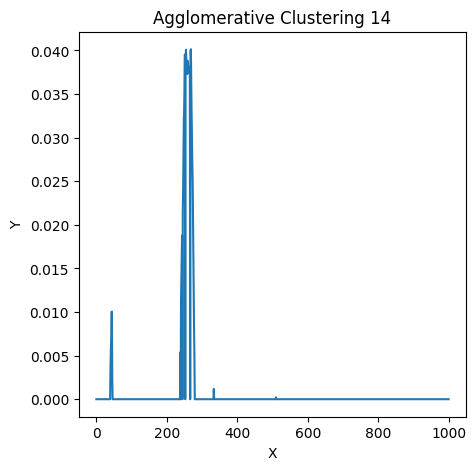

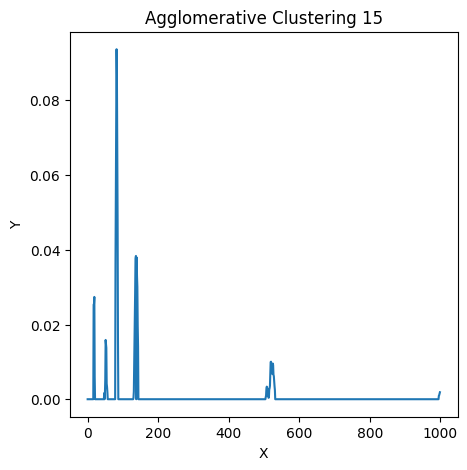

Number of components found: 83


In [31]:
#Mask 1 clustering
# Note: components needs to be transposed for AggCluster
AggComponents_1 = np.array(components).T
clusters = 16  # number of clusters you want
Understanding_data_1, found_compos_1 = AggCluster(clusters, AggComponents_1)

# found_compos identified components
print(f"Number of components found: {len(found_compos_1)}")

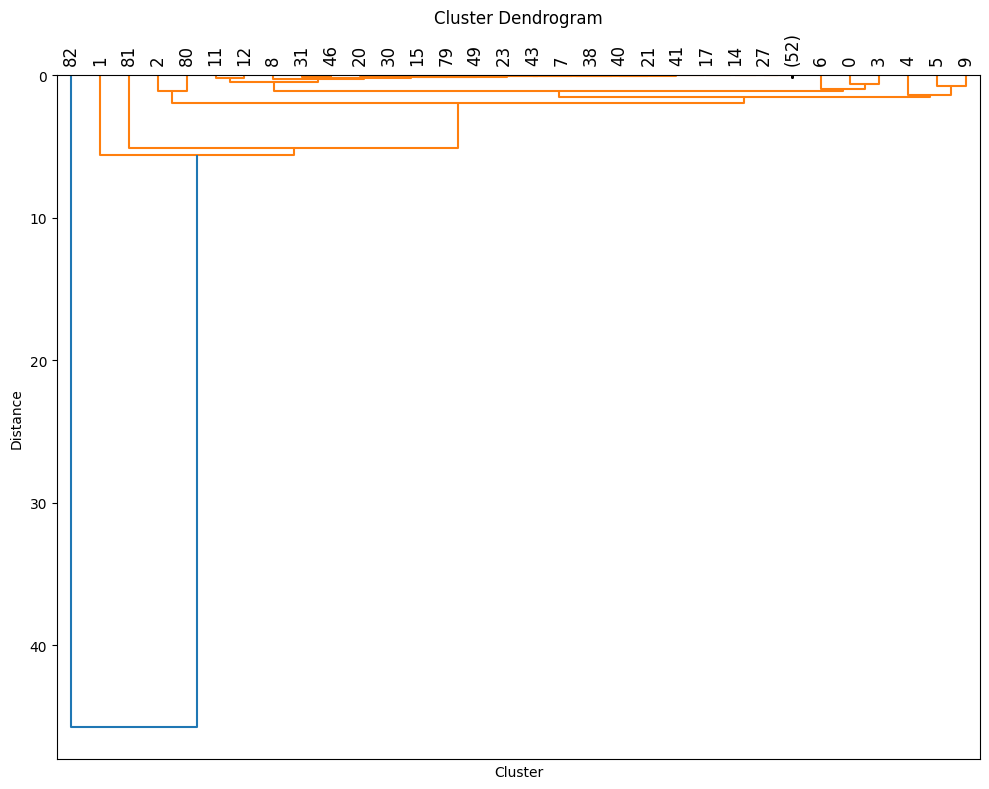

In [32]:
# Understanding_data, found_compos = iso.AggCluster(n_clusters, AggComponents)
plot_simple_dendrogram(AggComponents_1, n_clusters=16)

simdat grazing incidence test

Select calibrant:
1. AgBh
2. Al
3. alpha_Al2O3
4. Au
5. C14H30O
6. CeO2
7. Cr2O3
8. cristobaltite
9. CrOx
10. CuO
11. hydrocerussite
12. LaB6
13. LaB6_SRM660a
14. LaB6_SRM660b
15. LaB6_SRM660c
16. mock
17. NaCl
18. Ni
19. PBBA
20. Pt
21. quartz
22. Si
23. Si_SRM640
24. Si_SRM640a
25. Si_SRM640b
26. Si_SRM640c
27. Si_SRM640d
28. Si_SRM640e
29. TiO2
30. ZnO
Ni


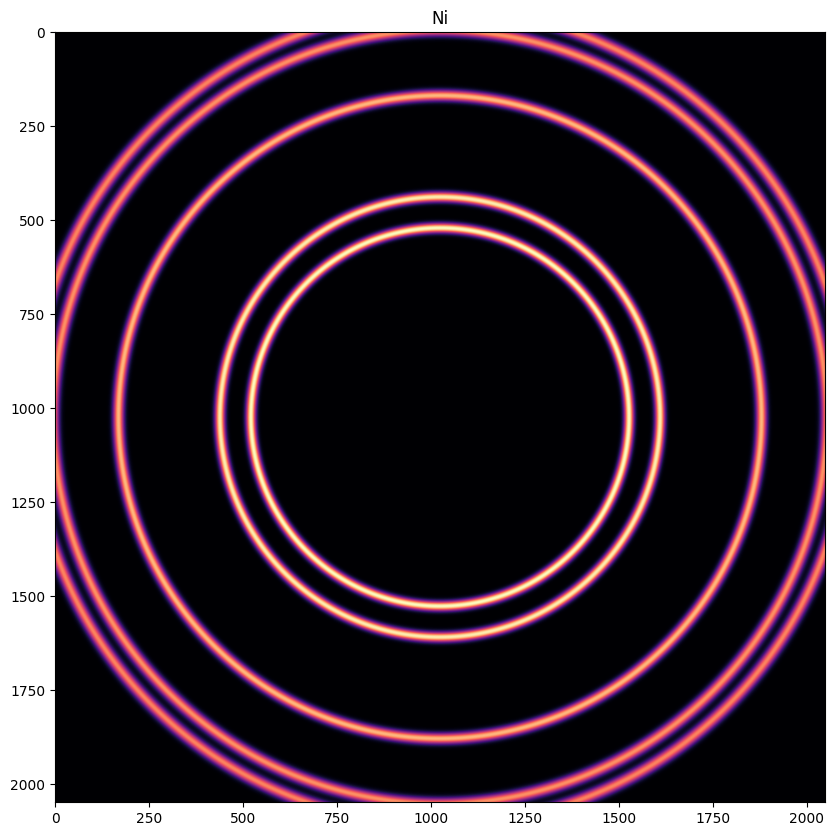

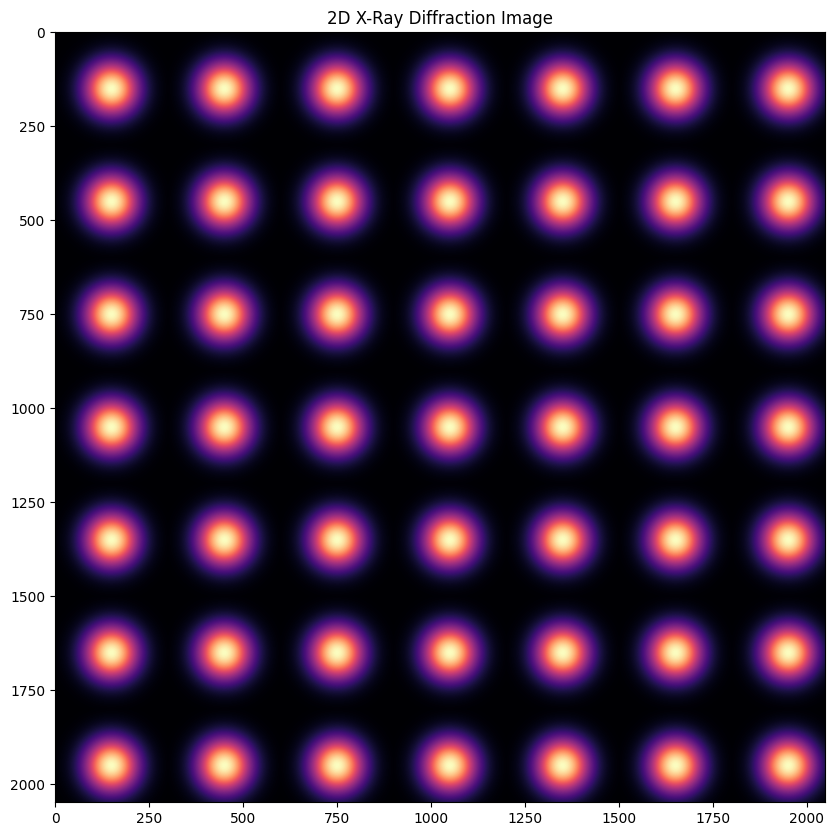

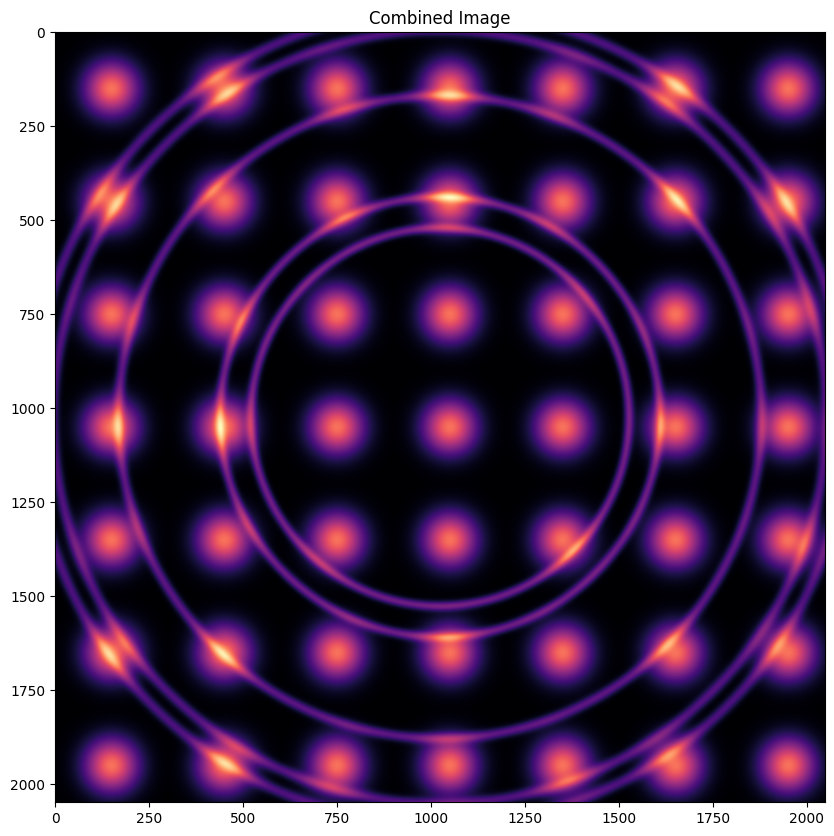

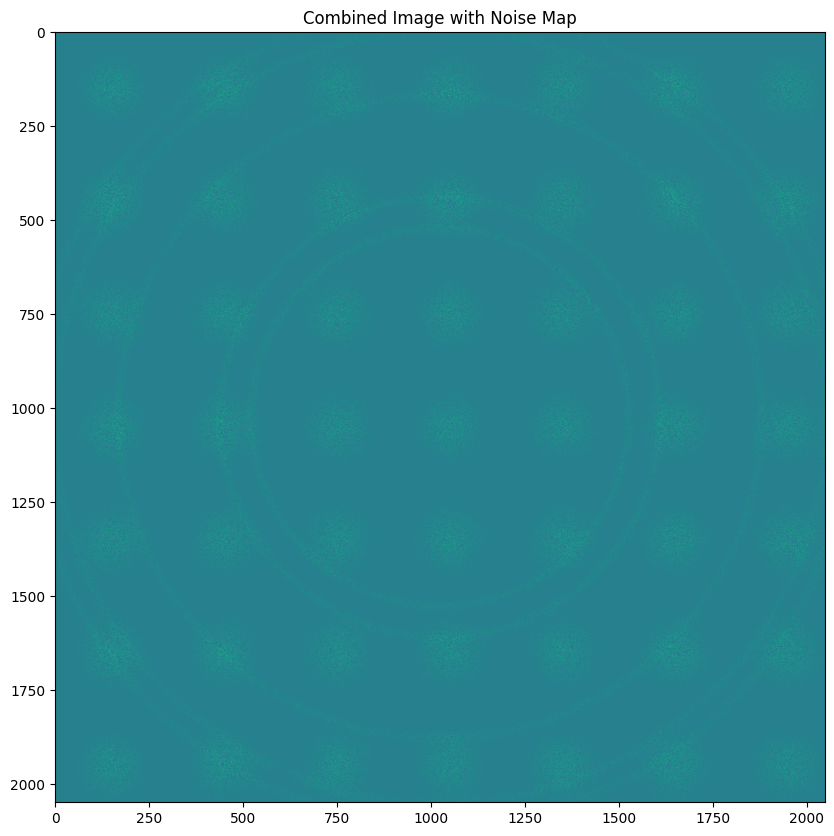

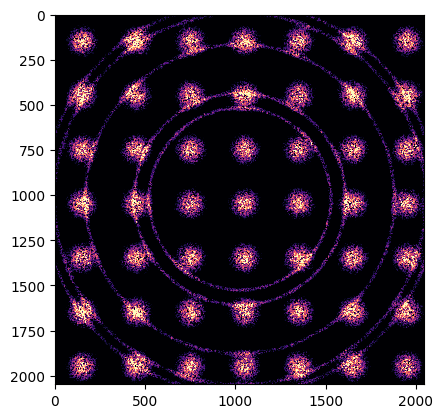

In [33]:
#For ring creation
isotropic_signal = sim.create_isotropic(.4, .5e-10, cmap = 'magma')
#For spot creation
anisotropic_signal = sim.create_anisotropic(25, 50, 300, 300, cmap = 'magma')
#combining signals 
thin_film = sim.combine_image(isotropic_signal, anisotropic_signal*2, cmap= 'magma')
#For noisy data
noisy_im = sim.generate_noisemap(thin_film);
plt.imshow(noisy_im, vmin = 1, vmax = 5, cmap = 'magma')

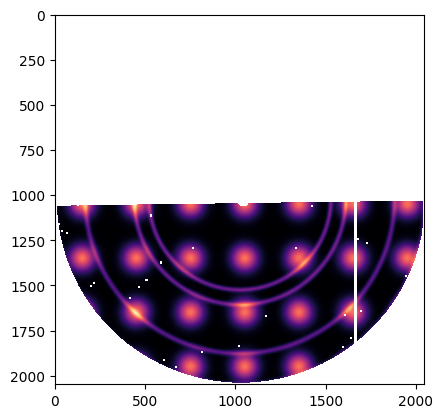

C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_29380\3660004555.py:42: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(window)


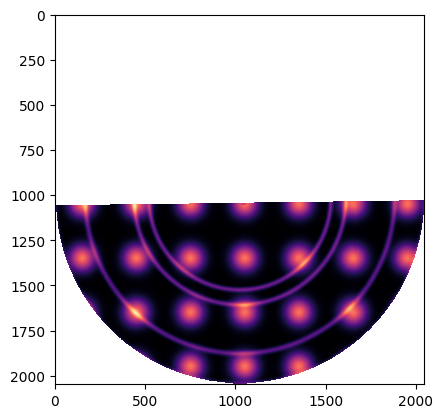

In [34]:
sim_combined_image = thin_film + gz_mask_with_nan
plt.imshow(sim_combined_image, cmap = 'magma')
plt.show()

sim_filled_with_mean = fill_nan_with_neighbor_mean_circle(sim_combined_image, radius = 1024, center = (1024, 1024))
plt.imshow(sim_filled_with_mean, cmap = 'magma')
plt.show()

C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_29380\2040456769.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{angle:.3f}"] = I
C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_29380\2040456769.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{angle:.3f}"] = I
C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_29380\2040456769.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

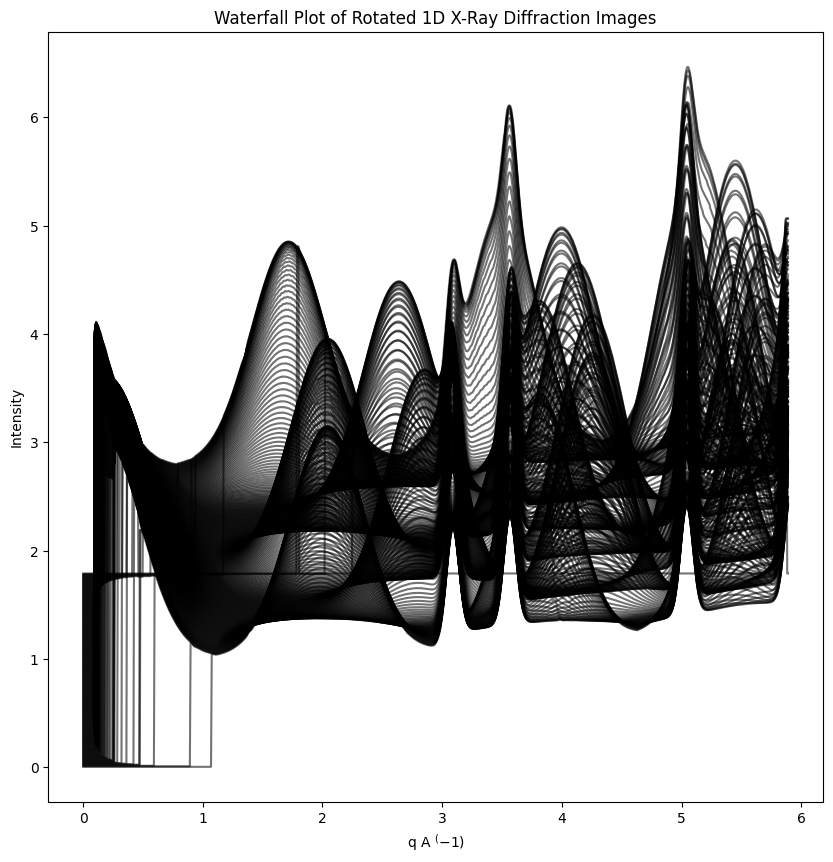

In [35]:
#using the same angle of rotation as the real data, but default distance and wavelength (no poni file)
q, sim_nanmean_mask12 = rotate_and_integrate(sim_filled_with_mean, 0.5, .4, .5e-10, resolution = 1000, mask = mask_12)

c:\Users\kelleymarisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\kelleymarisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\kelleymarisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\kelleymarisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\kelleymarisa\AppData\Local\Programs\Python\Python312\Lib\site-p

The beta-divergence is:  784.1867 %
 The final number of components used were 99 

Components shape: (1000, 98)


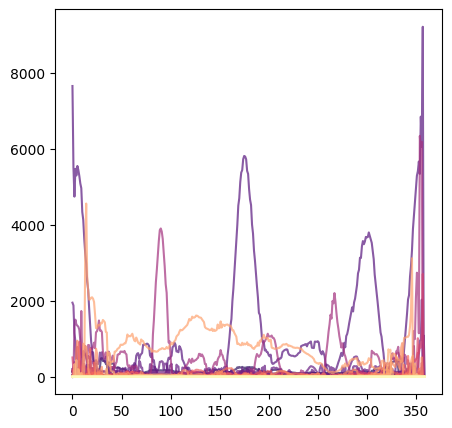

In [36]:
# Run NMF & HAC separately
# Mask 12 NMF
weights, components, beta = iso.Run_NMF(sim_nanmean_mask12, init=None, solver='cd', beta_loss='frobenius', itear=1000, show=True)

print(f"Components shape: {components.shape}")

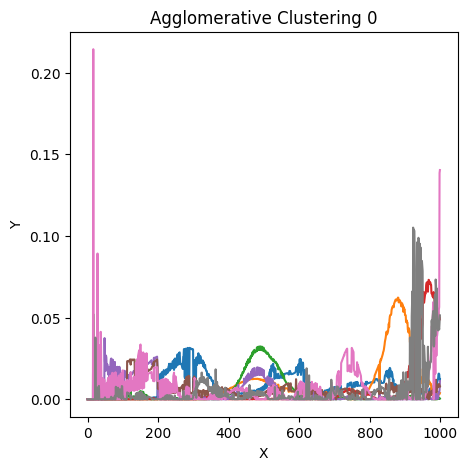

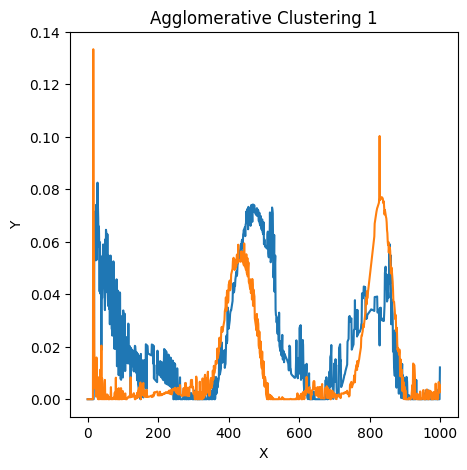

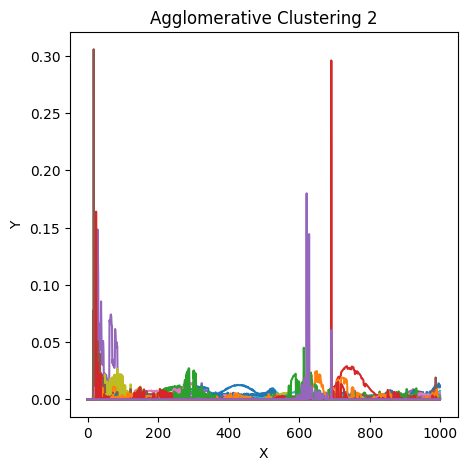

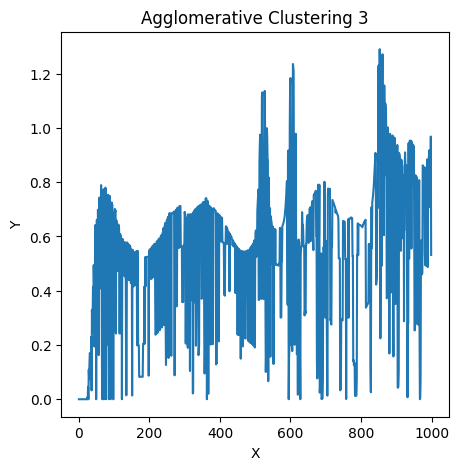

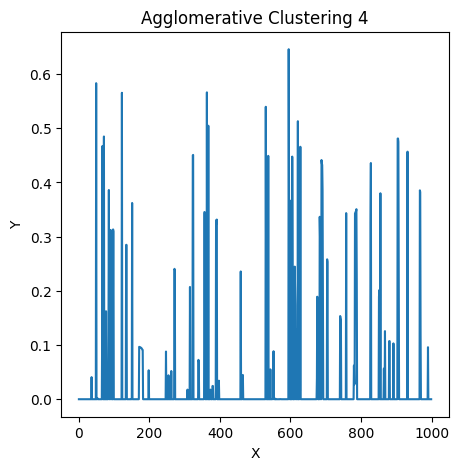

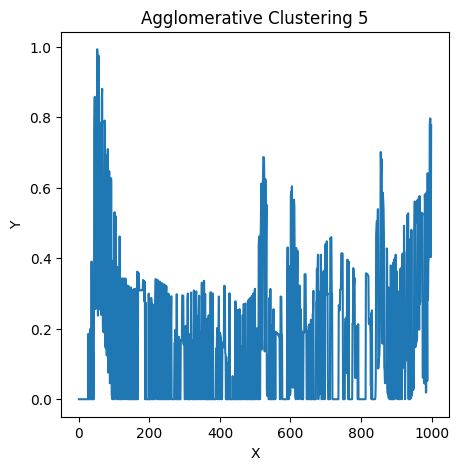

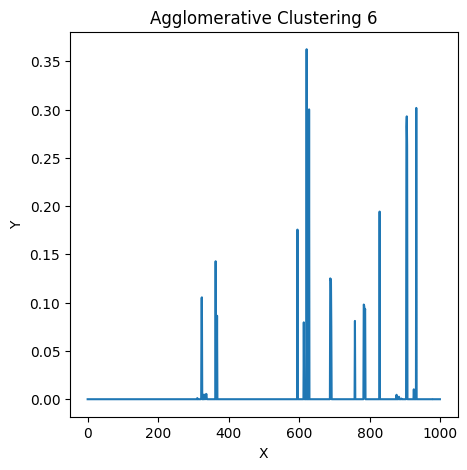

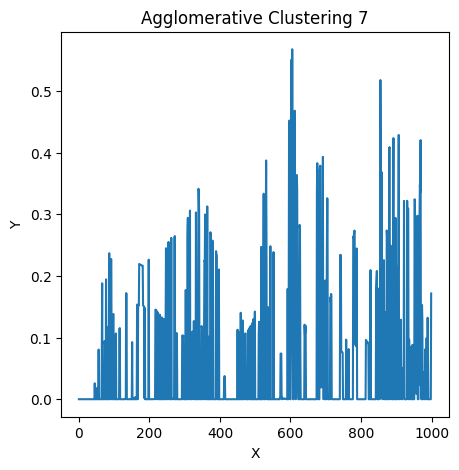

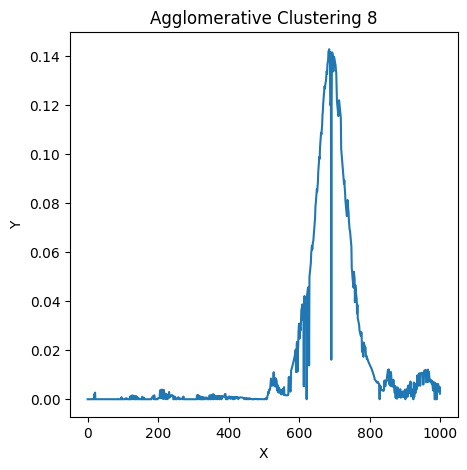

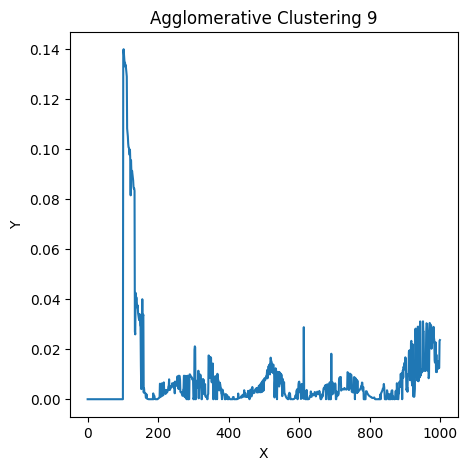

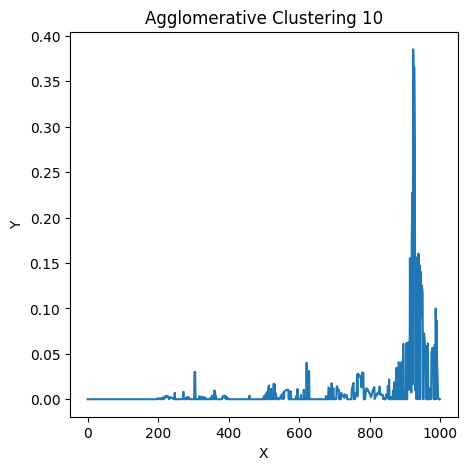

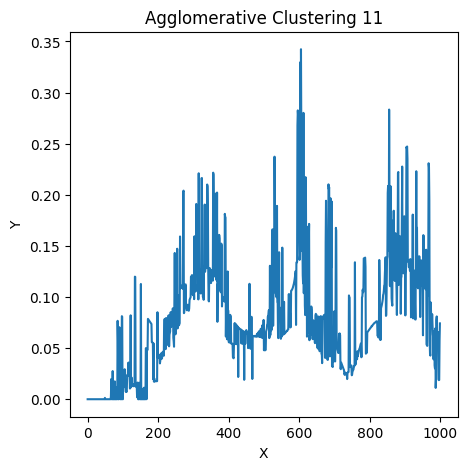

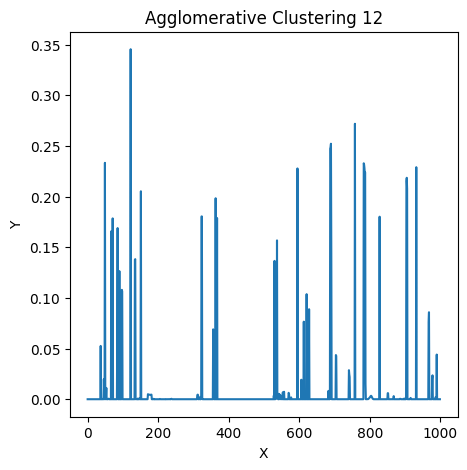

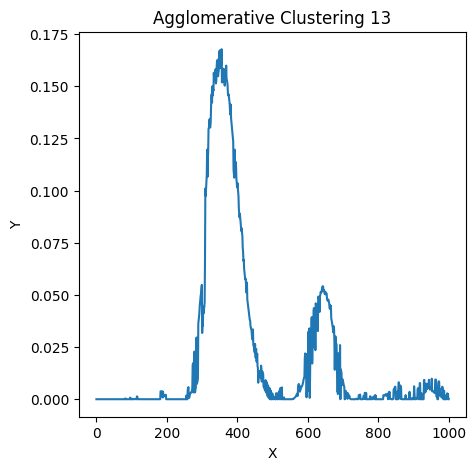

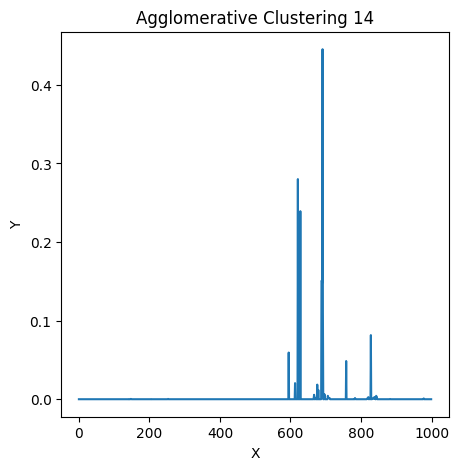

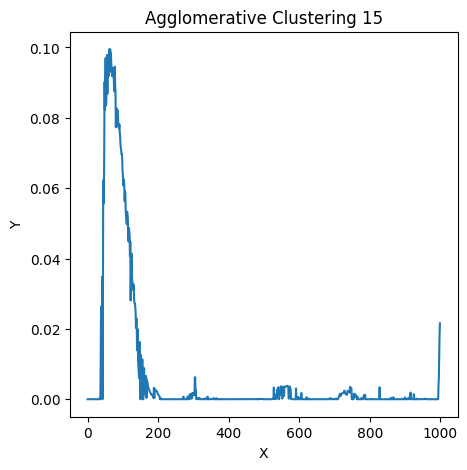

Number of components found: 98


In [37]:
# Note: components needs to be transposed for AggCluster
AggComponents_sim = np.array(components).T
clusters = 16  # number of clusters you want
Understanding_data, found_compos_sim = AggCluster(clusters, AggComponents_sim)

# found_compos identified components
print(f"Number of components found: {len(found_compos_sim)}")


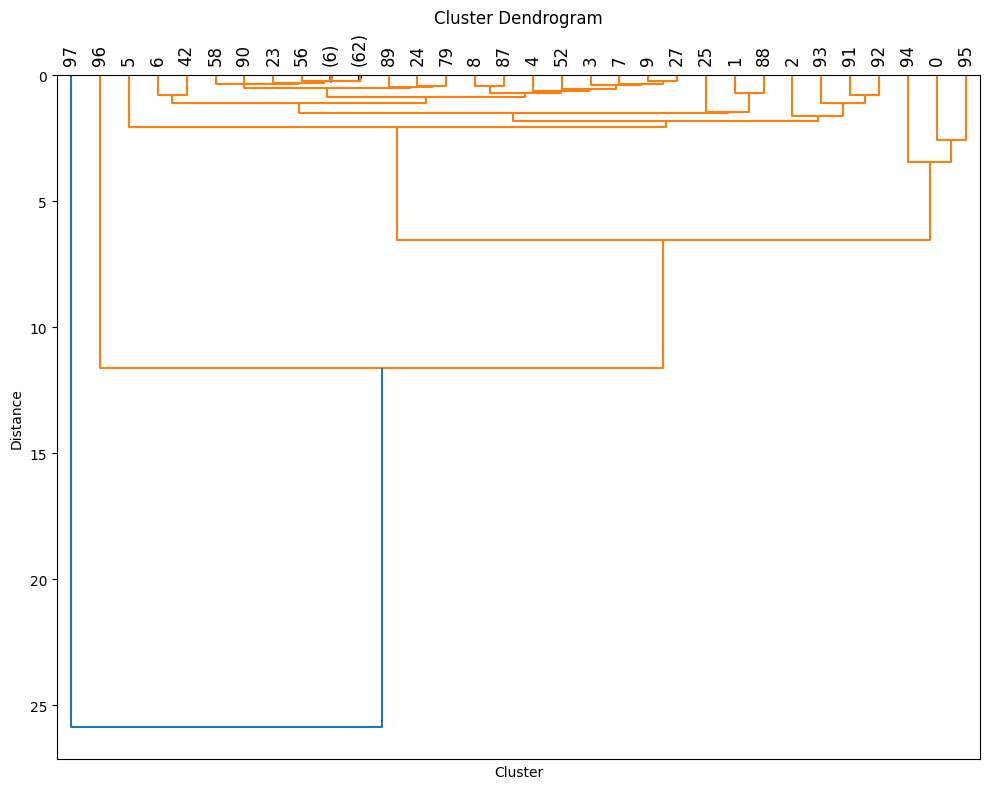

In [38]:
# Understanding_data, found_compos = iso.AggCluster(n_clusters, AggComponents)
plot_simple_dendrogram(AggComponents_sim, n_clusters=16)

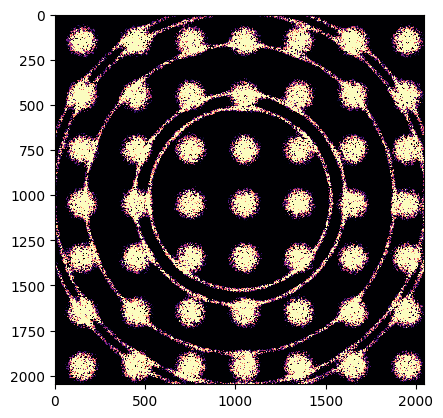

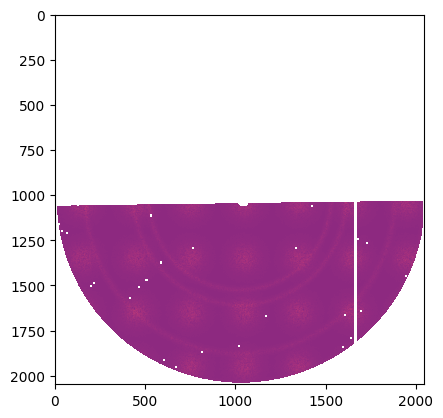

C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_29380\3660004555.py:42: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(window)


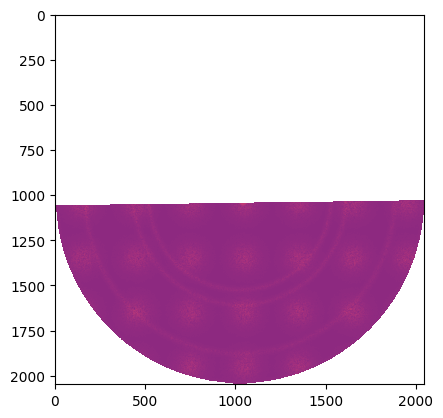

In [39]:
#For noisy data
#noisy_im = sim.generate_noisemap(thin_film);
plt.imshow(noisy_im, vmin = 1, vmax = 2, cmap = 'magma')

plt.show()
# with noise applied
sim_noise_combined_image = noisy_im + gz_mask_with_nan
plt.imshow(sim_noise_combined_image, cmap = 'magma')
plt.show()

sim_noise_filled_with_mean = fill_nan_with_neighbor_mean_circle(sim_noise_combined_image, radius = 1024, center = (1024, 1024))
plt.imshow(sim_noise_filled_with_mean, cmap = 'magma')
plt.show()

C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_29380\2040456769.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{angle:.3f}"] = I
C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_29380\2040456769.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{angle:.3f}"] = I
C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_29380\2040456769.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

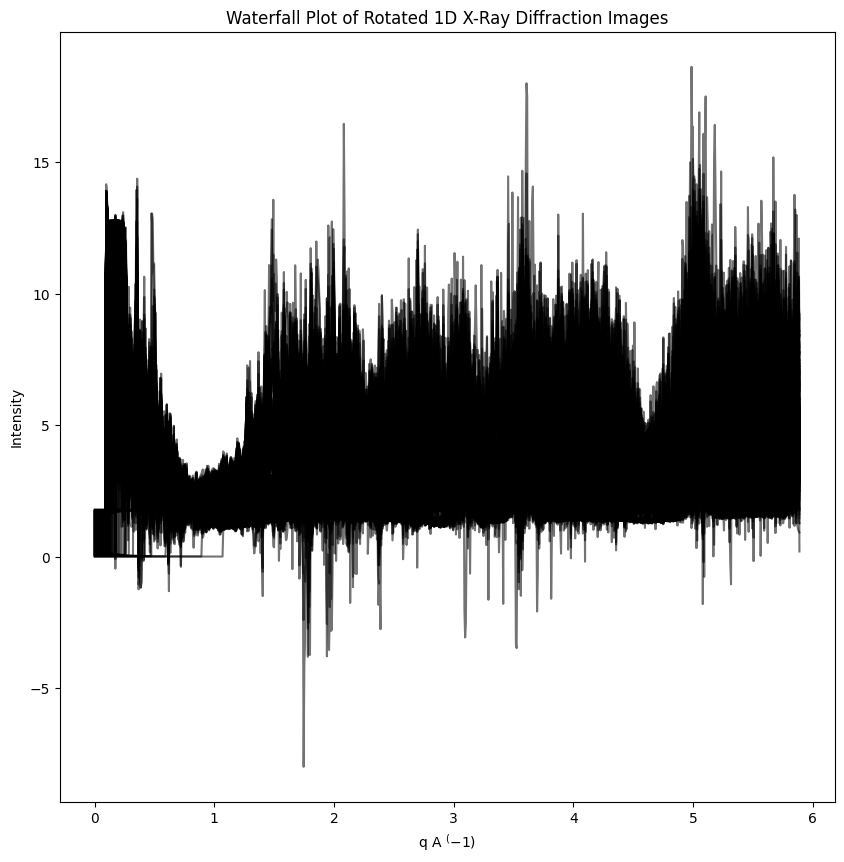

In [40]:
#using the same angle of rotation as the real data, but default distance and wavelength (no poni file)
q, sim_noise_nanmean_mask12 = rotate_and_integrate(sim_noise_filled_with_mean, 0.5, .4, .5e-10, resolution = 1000, mask = mask_12)

* substrate only data
* output of zero values after integration
* if able to see in .xy visualize in grace

substrate only data

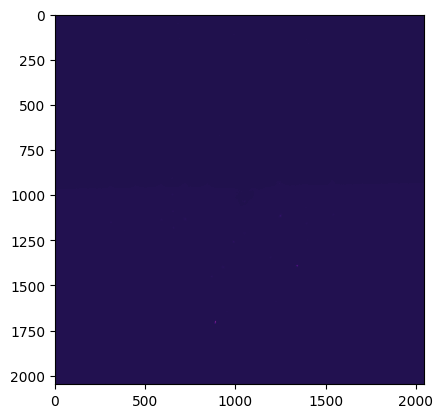

C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_29380\301934088.py:8: RuntimeWarning: divide by zero encountered in log1p
  Si_sub_111_scaled = np.log1p(Si_sub_111_image)
C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_29380\301934088.py:8: RuntimeWarning: invalid value encountered in log1p
  Si_sub_111_scaled = np.log1p(Si_sub_111_image)


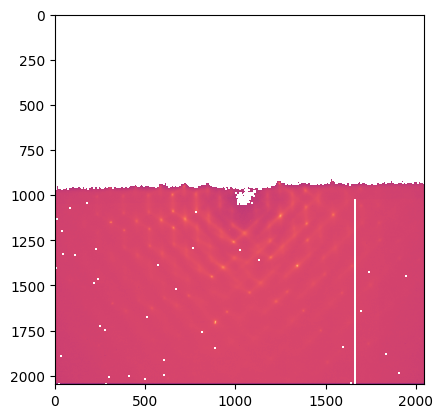

In [41]:
Si_sub_111 = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\p21p1\gits_Si_sub_111\gits_Si_sub_111_45_mdeg-00009.tif'
Si_sub_111_image = imread(Si_sub_111)
#check image
plt.imshow(Si_sub_111_image, cmap = 'magma')
plt.show()

# Log scale (add small number to avoid log(0))
Si_sub_111_scaled = np.log1p(Si_sub_111_image)
plt.imshow(Si_sub_111_scaled, cmap = 'magma')
plt.show()

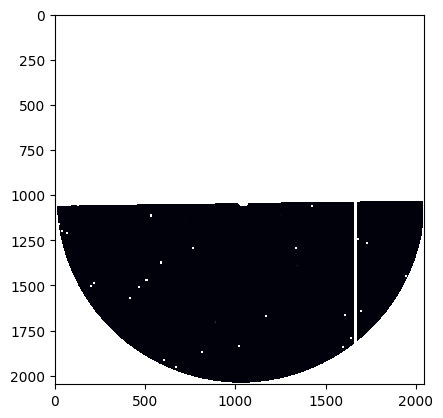

C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_29380\3660004555.py:42: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(window)


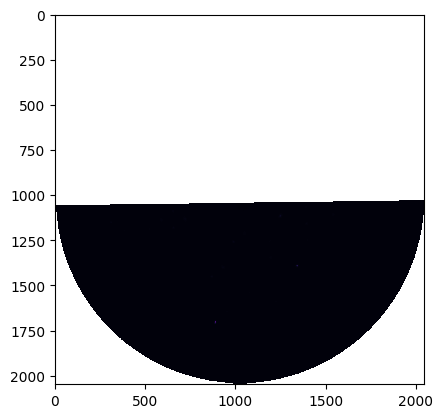

In [45]:
gz_sub_combined_image = Si_sub_111_image + gz_mask_with_nan
plt.imshow(gz_sub_combined_image, cmap = 'magma')
plt.show()
sub_filled_with_mean = fill_nan_with_neighbor_mean_circle(gz_sub_combined_image, radius = 1024, center = (1024, 1024))
plt.imshow(sub_filled_with_mean, cmap = 'magma')
#plt.show()

C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_29380\2040456769.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{angle:.3f}"] = I
C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_29380\2040456769.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{angle:.3f}"] = I
C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_29380\2040456769.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

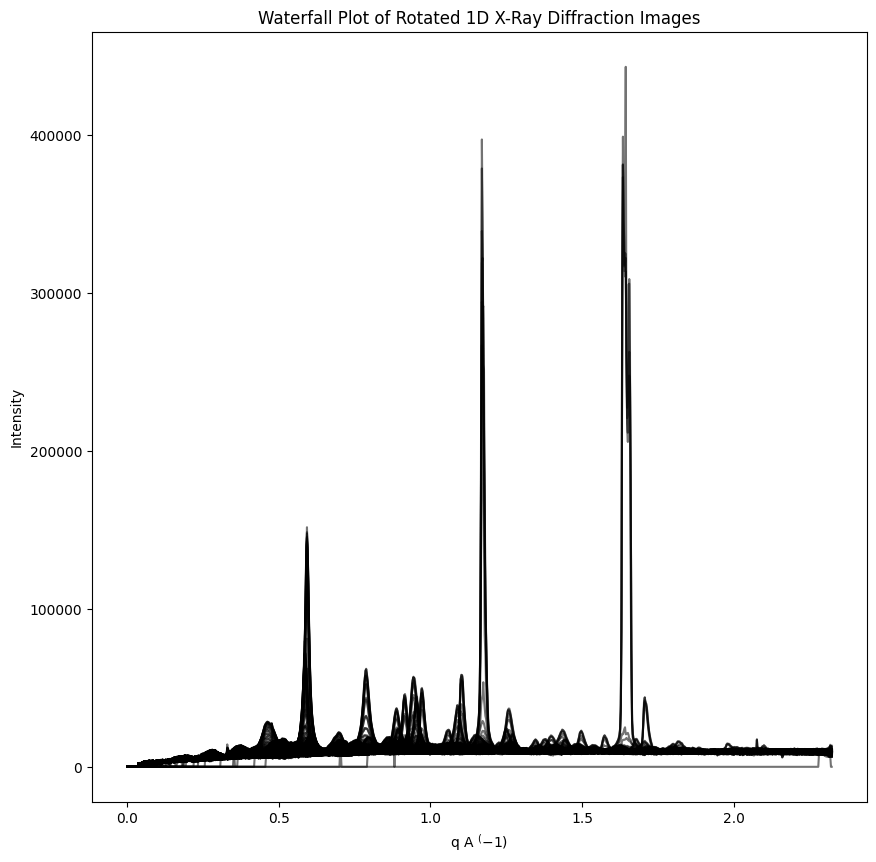

In [43]:
q, sub_nanmean_mask12 = rotate_and_integrate(sub_filled_with_mean, 0.5, .4179, 1.222e-10, resolution = 1000, mask = mask_12)

The beta-divergence is:  202713280.0 %
 The final number of components used were 163 

Components shape: (1000, 162)


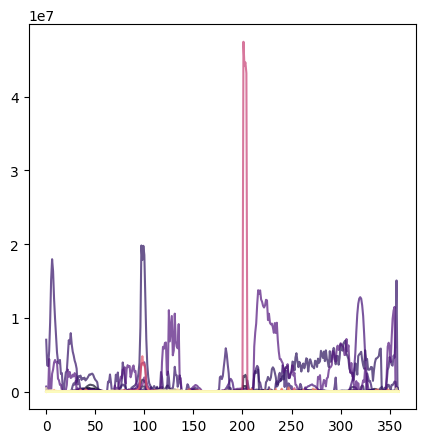

In [44]:
# Run NMF & HAC separately
# Mask 12 NMF
weights, components, beta = iso.Run_NMF(sub_nanmean_mask12, init=None, solver='cd', beta_loss='frobenius', itear=1000, show=True)
print(f"Components shape: {components.shape}")

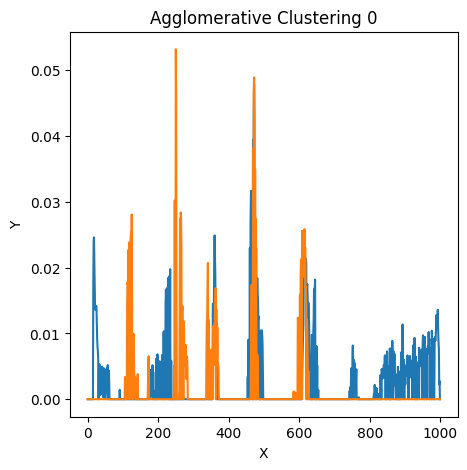

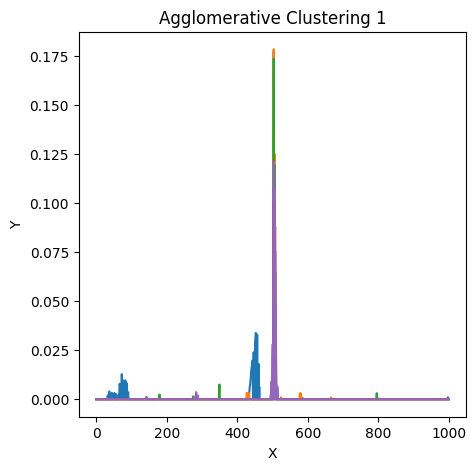

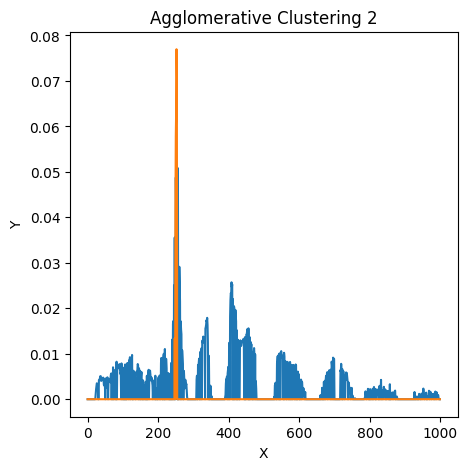

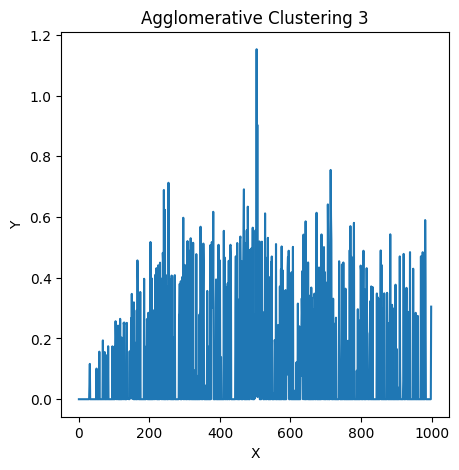

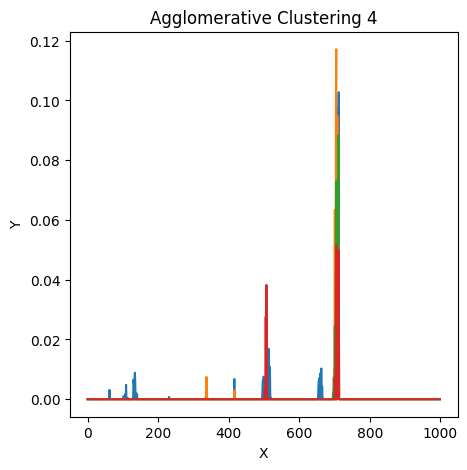

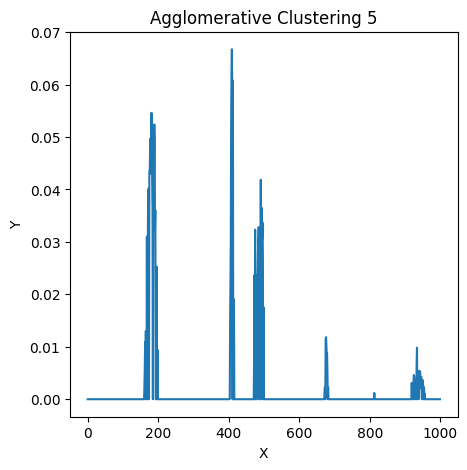

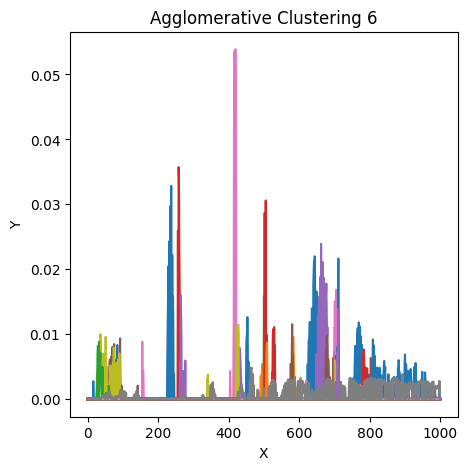

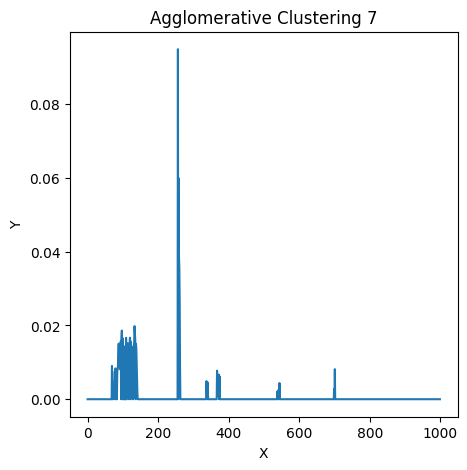

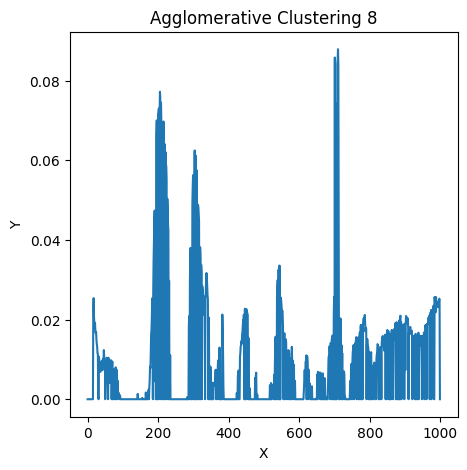

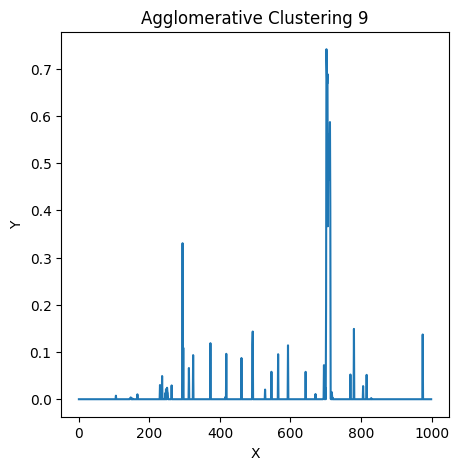

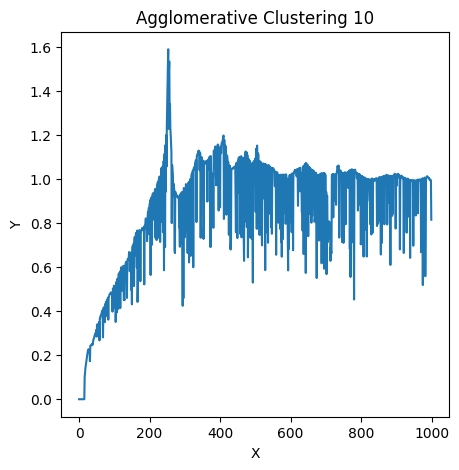

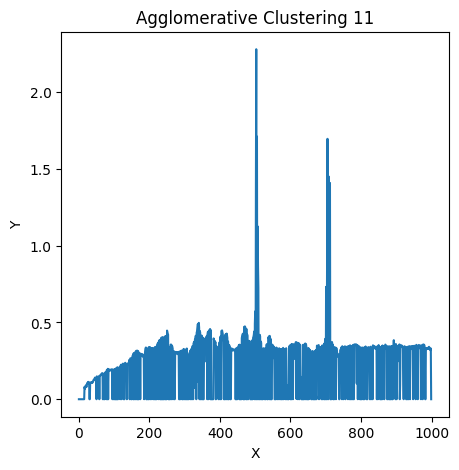

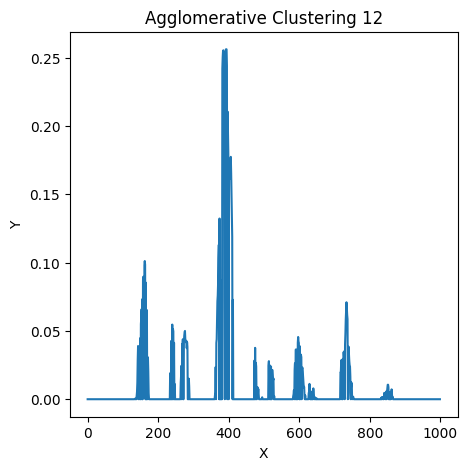

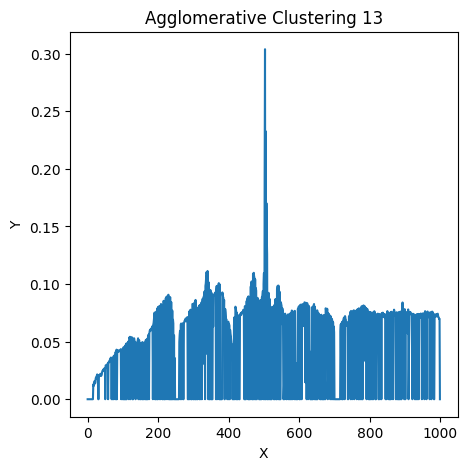

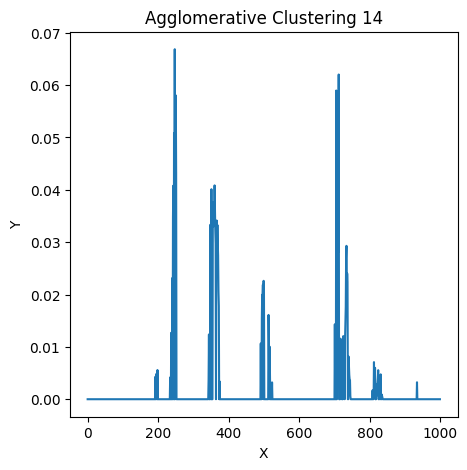

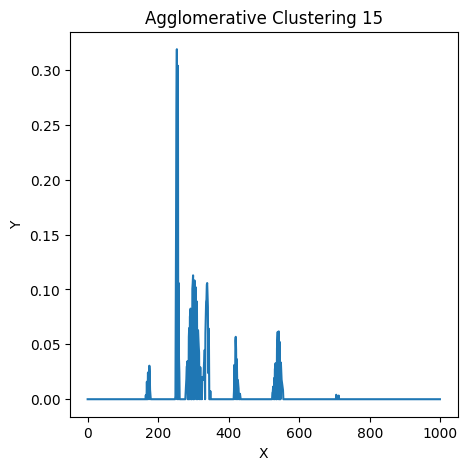

Number of components found: 162


In [46]:
# Note: components needs to be transposed for AggCluster
AggComponents_si = np.array(components).T
clusters = 16  # number of clusters you want
Understanding_data_si, found_compos_si = AggCluster(clusters, AggComponents_si)

# found_compos identified components
print(f"Number of components found: {len(found_compos_si)}")

silica substrate

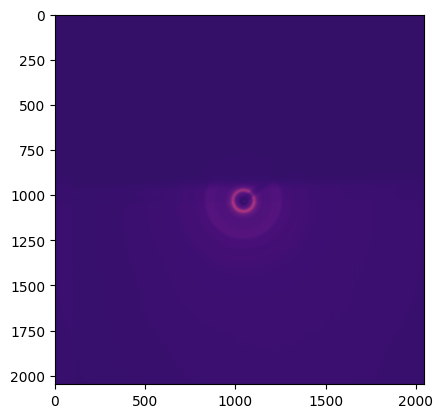

In [50]:
SiO2_sub = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\p21p1\gits_FusedSilica_Sub\gits_FusedSilica_45_mdeg-00062.tif'
SiO2_sub_image = imread(SiO2_sub)
#check image
plt.imshow(SiO2_sub_image, cmap = 'magma')
plt.show()

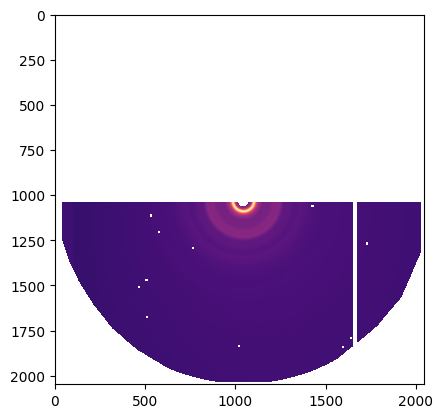

In [66]:
gz_sub_SiO2_combined_image = SiO2_sub_image + gz_mask_with_nan
plt.imshow(gz_sub_SiO2_combined_image, cmap = 'magma')
plt.show()
#sub_SiO2_filled_with_mean = fill_nan_with_neighbor_mean_circle(gz_sub_SiO2_combined_image, radius = 1024, center = (1024, 1024))

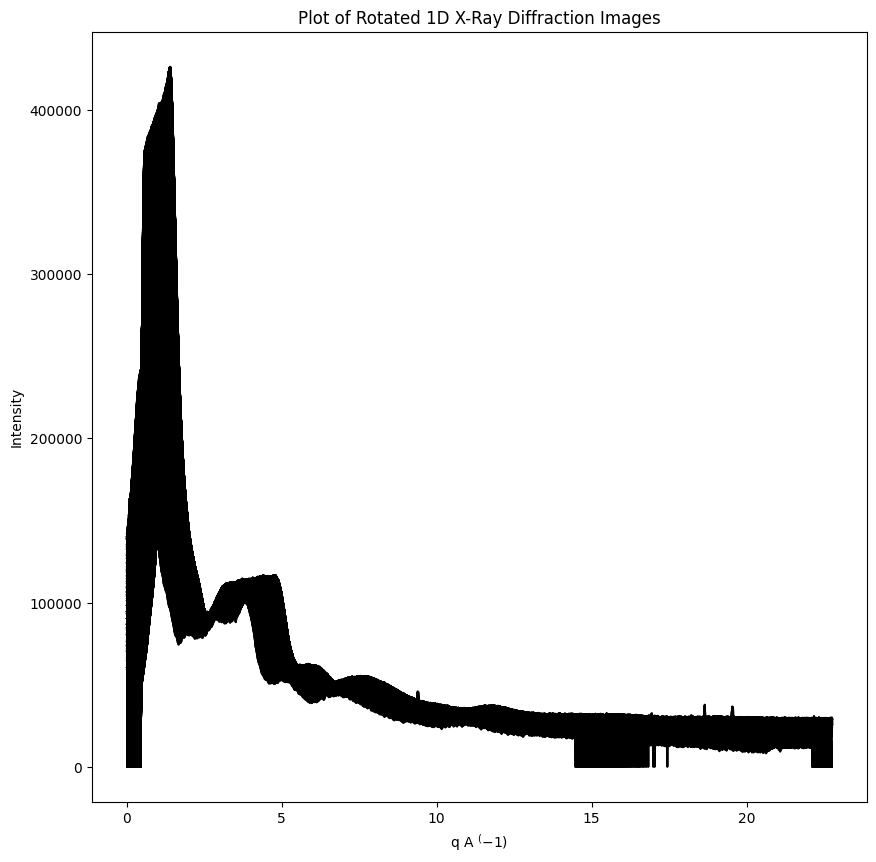

In [89]:
q, sub_SiO2_nanmean_mask12 = rotate_and_integrate(gz_sub_SiO2_combined_image, 0.25, .4179, 1.222e-11, resolution = 1000, mask = mask_12)

The beta-divergence is:  744434500.0 %
 The final number of components used were 31 

Components shape: (1000, 30)


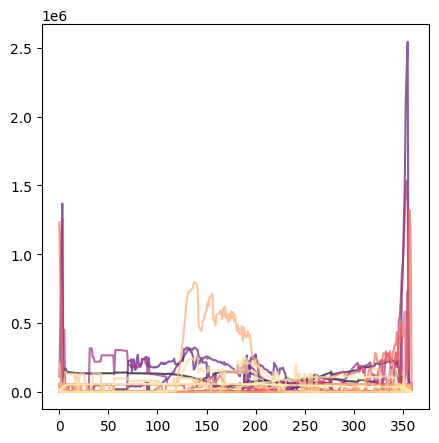

In [53]:
# Run NMF & HAC separately
# Mask 12 NMF
weights, components, beta = iso.Run_NMF(sub_SiO2_nanmean_mask12, init=None, solver='cd', beta_loss='frobenius', itear=1000, show=True)
print(f"Components shape: {components.shape}")

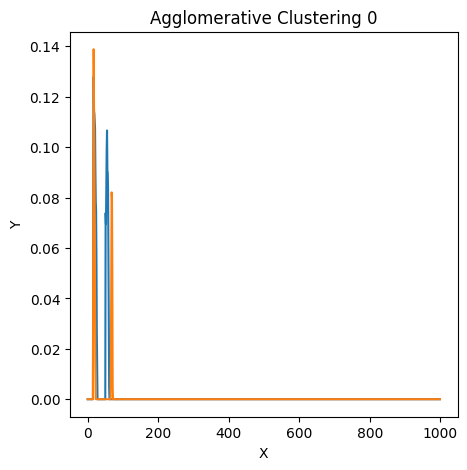

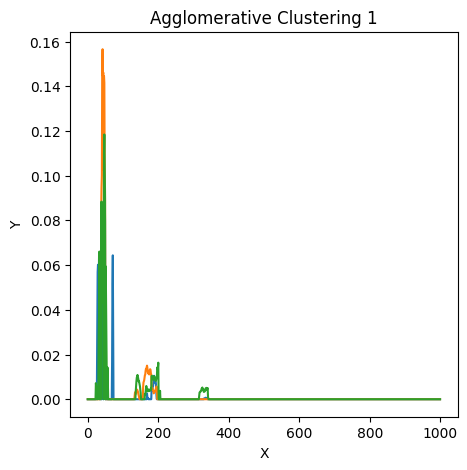

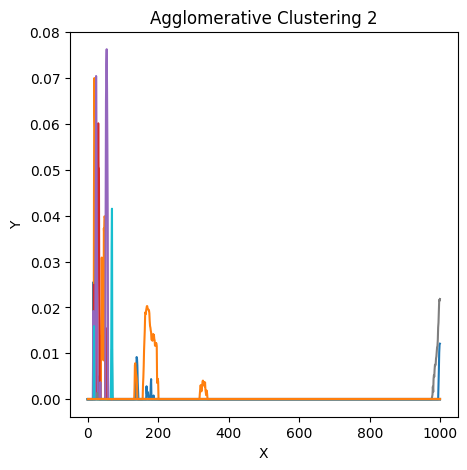

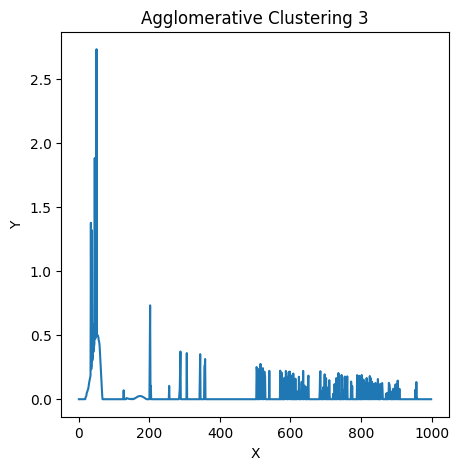

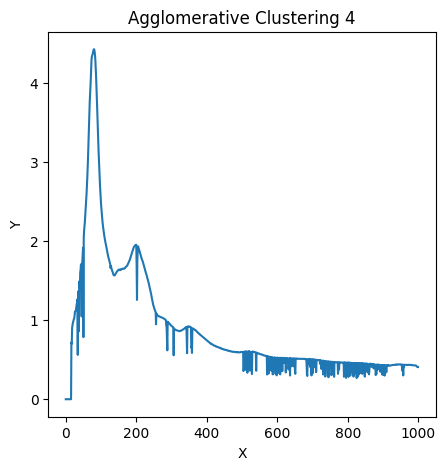

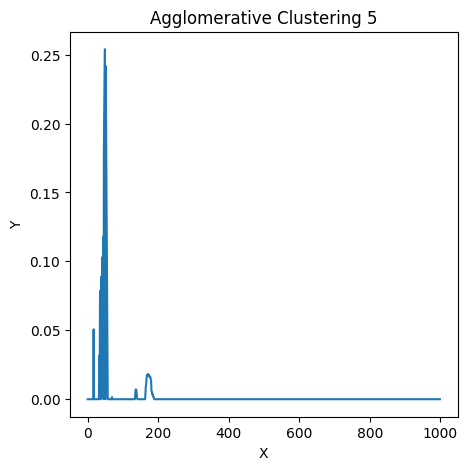

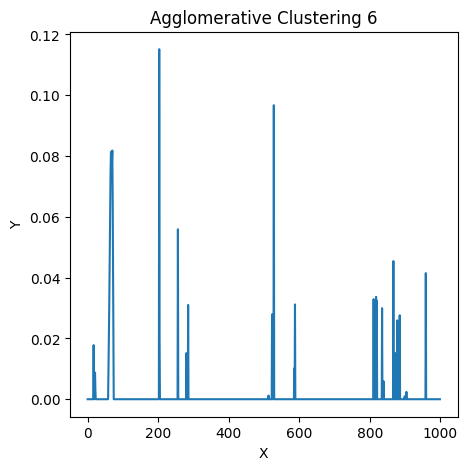

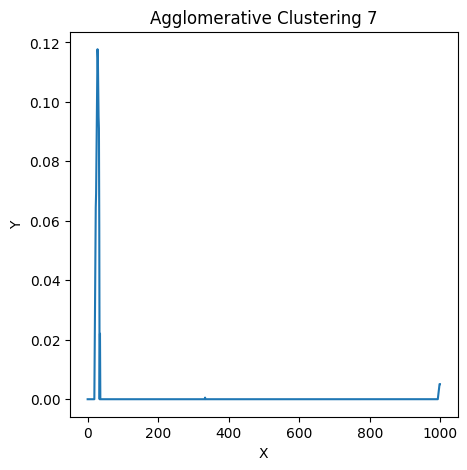

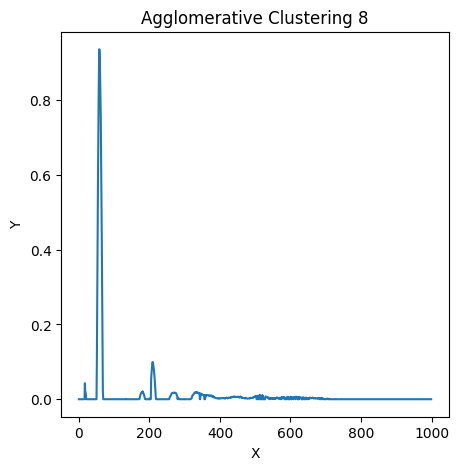

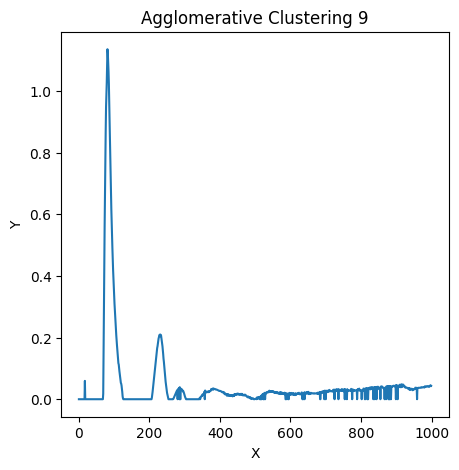

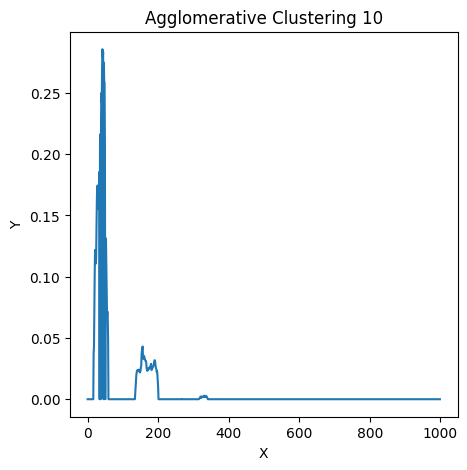

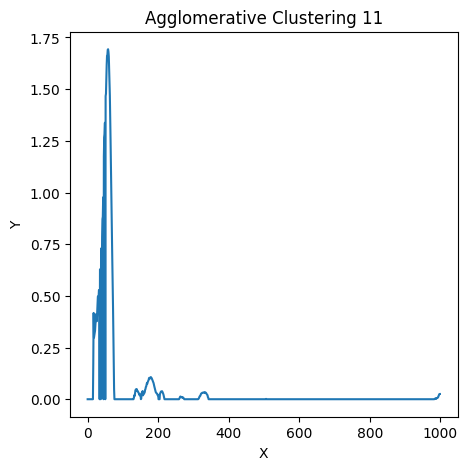

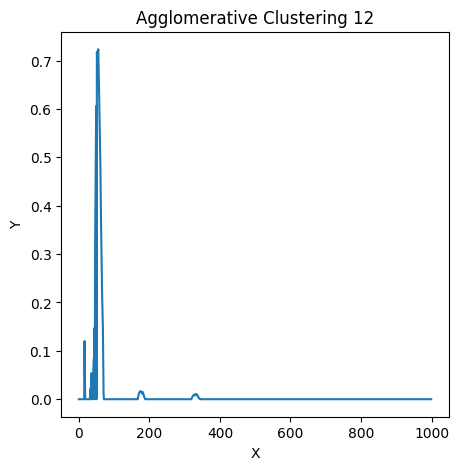

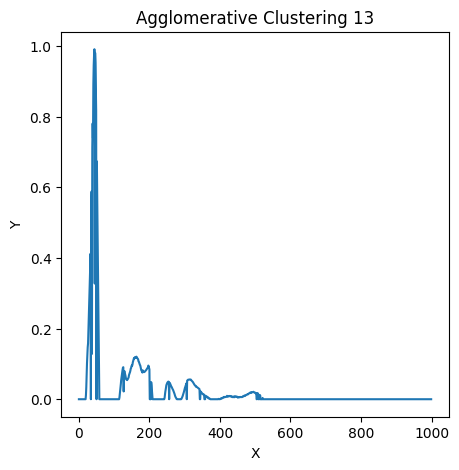

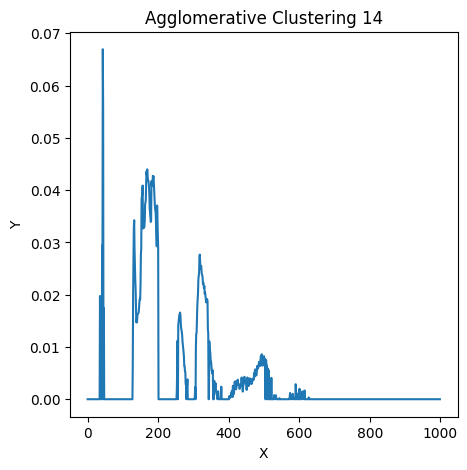

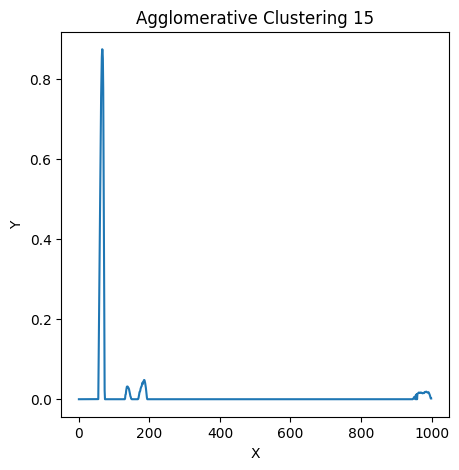

Number of components found: 30


In [54]:
# Note: components needs to be transposed for AggCluster
AggComponents_sio2 = np.array(components).T
clusters = 16  # number of clusters you want
Understanding_data_sio2, found_compos_sio2 = AggCluster(clusters, AggComponents_sio2)
# found_compos identified components
print(f"Number of components found: {len(found_compos_sio2)}")

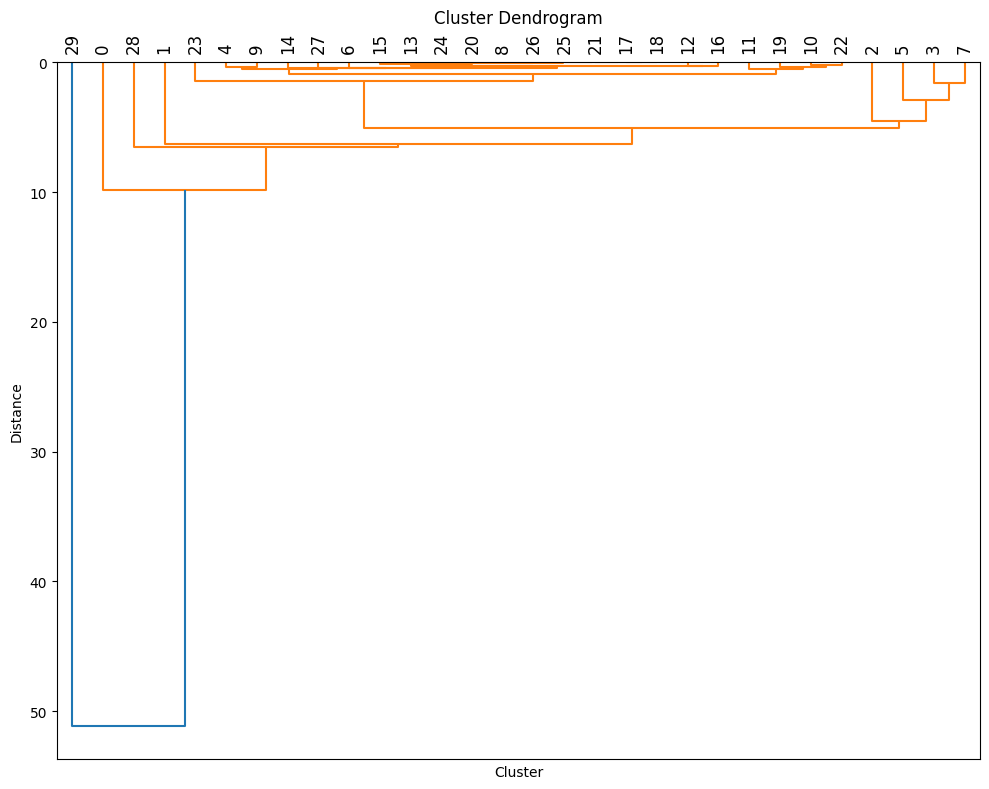

In [55]:
# Understanding_data, found_compos = iso.AggCluster(n_clusters, AggComponents)
plot_simple_dendrogram(AggComponents_sio2, n_clusters=16)